# Project PHYS512 - Matias Castro Tapia

In [1]:
import numpy as np
import numba as nb
import time
from matplotlib import pyplot as plt
from scipy import fft
from matplotlib.animation import FuncAnimation
from IPython import display
from astropy import units as u
from matplotlib.animation import PillowWriter
from scipy import special

I started with Professor Sievers' code for taking the N-body simulations using the convolution between the density in a map and a function of the position for obtaining the potential. I modified the code in different parts in order to use it for what I want. Then,
$$V(x)=-G \int \frac{\rho(r)}{|x-r|} d^{3}r =-G \rho(x)*\frac{1}{|x|}$$
and if we have a map for the density and the function for the distance we can use the Fourier transform to take the product for the convolution and obtain the potential.

For taking the map for the function I used the get_kernel function with a softened radius, i.e., we will not consider the influence of the function when the distance is less than the softened radius, this because the function $\frac{1}{|x|}$ goes to infinity when is near to 0.

Below, I show how does it look the map for the function using a map of 25x25. I  used the logarithmic scale because the function decreases quickly near 0.

In [5]:
n=25
rsoft=0.01
x=np.fft.fftfreq(n)*n
rsqr=np.outer(np.ones(n),x**2)
rsqr=rsqr+rsqr.T
rsqr[rsqr<rsoft**2]=rsoft**2
kernel=rsqr**-0.5

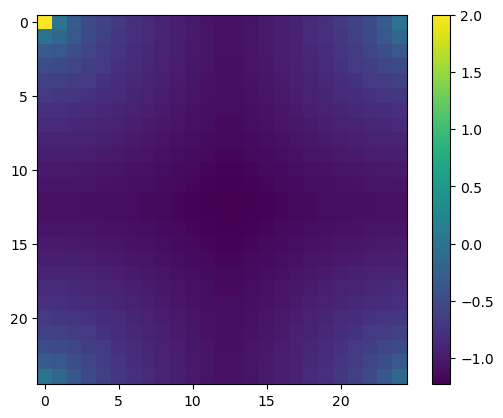

In [6]:
plt.imshow(np.log10(kernel))
plt.colorbar()

The code defines the set of particles as a class, then there are internals methods in the class for obtaining the kernel and the density maps for the set of particles.

The density could be obtained using the hist2d_wmass function, which look at the position of each particle and takes the integer of the position (+0.5) and sum the mass that correspond for the position in the map. Then in the map we will have the total mass in every grid pixel, i.e., the mass normalized per unit of pixel square.

For obtaining the potential the method get_pot takes the convolution of the map of the function of distance and density using $IFT(FT[f]FT[\rho])$. For obtaining the force from the potential the function get_grad takes the positions, the map for the potential, and an empty array with length npartsx2 and obtains the numerical derivatives in the direction x and y for the closest pixel in the grid for each position. As the potential that we obtained is not the potential energy and it is equivalent to $V=U/m$ for $m$ a mass that is affected for the potential, then derivative will be acceleration since $a=F/m=-\nabla{V}$. We can ignore the G constant for now and the sign, because I also ignored them in the potential, i.e., I'm taking $V^{*}=\int \frac{\rho(r)}{|x-r|} d^{3}r$ then the acceleration is just $a=\nabla V^{*}$.

For taking a step in the code I used take_step or take_step_rk4. For take_step the position and velocity will change for a fixed time step $dt$ as: $x_{i+1}=x_{i}+v_{i}dt$ and $v_{i+1}=v_{i}+a_{i}dt$, while take_step_rk4 uses the Runge Kutta method.

On the othe hand, the instance variables are the masses, positions, number of particles, maps for rho a the function, dimension of the grid, the soft radius, the potencial, and forces. Moreover, there is a variable to set periodic and non-periodic boundary conditions. When periodic, if a particle is about to go out of the grid, i.e., its position in x or y becomes <0.5 or >ngrid-0.5, the position es updated to be in the opposite boundary. However, if non-periodic, when a paricle fell out of the region <0.5 or >ngrid-0.5 for x or y, its mass is updated to be 0 and its position to be ngrid in the coordinate, then, these particles do not contribute for the potential when cross the grid.

In [127]:
def inbound_array_np(xy,n):
    xy[xy<-0.5]=xy[xy<-0.5]+n
    xy[xy>=n-0.5]=xy[xy>=n-0.5]-n

def mask_array_np(xy,m,n):
    for i in range(xy.shape[1]):
        m[xy[:,i]<-0.5]=0
        m[xy[:,i]>=n-0.5]=0
        xy[xy<-0.5]=n
        xy[xy>=n-0.5]=n
        
    
#@nb.njit(parallel=True)
def get_grad(xy,pot,grad):
    #n=xy.shape[0]
    n=pot.shape[0]
    for i in nb.prange(xy.shape[0]):
        #if i>=n-5:
         #   i=n-5
        if xy[i,0]<0 or xy[i,0]>n:
            ix0=n-1
            ix1=0
            fx=xy[i,0]+1
        else:
            ix0=int(xy[i,0])
            ix1=ix0+1
            fx=xy[i,0]-ix0
            if ix1==n:
                ix1=0
        if xy[i,1]<0 or xy[i,1]>n:
            iy0=n-1
            iy1=0
            fy=xy[i,1]+1
        else:
            iy0=int(xy[i,1])
            iy1=iy0+1
            fy=xy[i,1]-iy0
            if iy1==n:
                iy1=0
        #potential is f00(1-fx)(1-fy)+f01(1-fx)(fy)+f10(fx)(1-fy)+f11(fx)(fy)
        #grad_x is -f00(1-fy)-f01(fy)+f10(1-fy)+f11(fy)
        #grad_y is -f00(1-fx)+f01(1-fx)-f10(fx)+f11(fx)
        #grad[i,0]=pot[ix0,iy0]*(fy-1)-pot[ix0,iy1]*fy+pot[ix1,iy0]*(1-fy)+pot[ix1,iy1]*ft
        grad[i,0]=(pot[ix1,iy1]-pot[ix0,iy1])*fy+(pot[ix1,iy0]-pot[ix0,iy0])*(1-fy)
        grad[i,1]=(pot[ix1,iy1]-pot[ix1,iy0])*fx+(pot[ix0,iy1]-pot[ix0,iy0])*(1-fx)

        #fy0=pot[ix0,iy0]*(1-fy)+pot[ix0,iy1]*fy
        #fy1=pot[ix1,iy0]*(1-fy)*pot[ix1,iy1]*fy
        #grad[i,0]=fy0*(1-fx)+fy1*fx

        #fx0=pot[ix0,iy0]*(1-fx)+pot[ix1,iy0]*fx
        #fx1=pot[ix0,iy1]*(1-fx)*pot[ix1,iy1]*fx
        #grad[i,1]=fx0*(1-fy)+fx1*fy
        

def hist2d_wmass(xy,mat,m):
    nx=xy.shape[0]
    nn=mat.shape[0]
    #print(nn)
    for i in range(nx):
        ix=int(xy[i,0]+0.5)
        iy=int(xy[i,1]+0.5)
        if m[i]>0:
            if ix<nn and iy<nn:  #we can set m=0 to flag particles
                mat[ix,iy]=mat[ix,iy]+m[i]
    
def get_kernel(n,r0):
    x=np.fft.fftfreq(n)*n
    rsqr=np.outer(np.ones(n),x**2)
    rsqr=rsqr+rsqr.T
    rsqr[rsqr<r0**2]=r0**2
    kernel=rsqr**-0.5
    return kernel


class particles:
    def __init__(self,npart=10000,n=1000,soft=1,periodic=True):
        self.x=np.empty([npart,2])
        self.f=np.empty([npart,2])
        self.v=np.empty([npart,2])
        self.grad=np.empty([npart,2])
        self.m=np.empty(npart)
        self.kernel=[]
        self.kernelft=[]
        self.npart=npart
        self.ngrid=n
        if periodic:
            self.rho=np.empty([self.ngrid,self.ngrid])
            self.pot=np.empty([self.ngrid,self.ngrid])
        else:
            self.rho=np.empty([2*self.ngrid,2*self.ngrid])
            self.pot=np.empty([2*self.ngrid,2*self.ngrid])

        self.soft=soft
        self.periodic=periodic
    def ics_gauss(self):
        self.x[:]=np.random.randn(self.npart,2)*(self.ngrid/12)+self.ngrid/2
        self.m[:]=1
        self.v[:]=0
        
    def get_kernel(self):
        if self.periodic:
            self.kernel=get_kernel(self.ngrid,self.soft)
            #print(self.kernel)
            #plt.imshow(np.log10(self.kernel))
            #plt.colorbar()
        else:
            self.kernel=get_kernel(2*self.ngrid,self.soft)
        self.kernelft=fft.rfft2(self.kernel)
    def get_rho(self):
        if self.periodic:
            inbound_array_np(self.x,self.ngrid)
        else:
            mask_array_np(self.x,self.m,self.ngrid)
        self.rho[:]=0
        hist2d_wmass(self.x,self.rho,self.m)
        #print(hist2d_wmass(self.x,self.rho,self.m))
        #plt.imshow(hist2d_wmass(self.x,self.rho,self.m))
        #plt.colorbar()
    def get_pot(self):
        t1=time.time()
        self.get_rho()
        #print('got density: ',time.time()-t1)
        rhoft=fft.rfft2(self.rho)
        #print('got ft 1: ',time.time()-t1)
        n=self.ngrid
        if not(self.periodic):
            n=n*2
        #self.pot=fft.irfft2(rhoft*self.kernelft,[self.ngrid,self.ngrid])
        self.pot=fft.irfft2(rhoft*self.kernelft,[n,n])
        #print('got ft 2: ',time.time()-t1)
    def get_forces(self):
        get_grad(self.x,self.pot,self.grad)
        self.f[:]=self.grad
    def take_step(self,dt=1):
        self.x[:]=self.x[:]+dt*self.v
        self.get_pot()
        self.get_forces()
        self.v[:]=self.v[:]+self.f*dt
   
        
        
    def take_step_rk4(self,dt=1):
        #xx=np.vstack([self.x,self.v])
        v=self.v.copy()
        x=self.x.copy()
        self.get_pot()
        pot=self.pot.copy()
        #pot.append(np.zeros(10))
        #pot=np.array(pot)
        grad1=np.zeros([self.npart,2])
        grad2=np.zeros([self.npart,2])
        grad3=np.zeros([self.npart,2])
        grad4=np.zeros([self.npart,2])
        
        get_grad(x,pot,grad1)
        f=grad1.copy()
        k1v=f#np.vstack([v,f])#get_derivs(xx)
        k1x=v
        
        get_grad(x+k1x*dt/2,pot,grad2)
        f2=grad2.copy()
        k2v=f2
        k2x=v+k1v*dt/2
        
        get_grad(x+k2x*dt/2,pot,grad3)
        f3=grad3.copy()
        k3v=f3
        k3x=v+k2v*dt/2
        
        get_grad(x+k3x*dt,pot,grad4)
        f4=grad4.copy()
        k4v=f4
        k4x=v+k3v*dt
        
        totx=(k1x+2*k2x+2*k3x+k4x)/6
        totv=(k1v+2*k2v+2*k3v+k4v)/6
        #nn=x.shape[0]
        self.x[:]=self.x[:]+totx*dt
        self.v[:]=self.v[:]+totv*dt
    


Let's probe that a single particle starting at rest remains motionless.

In [81]:
parts1=particles(npart=1,n=100,soft=2,periodic=True)

I just took a random position.

In [82]:
parts1.x=np.random.rand(parts1.npart,2)*parts1.ngrid
parts1.v=np.zeros((parts1.npart,2))

And mass to be 1. We are using arbitrary units since we are ignoring the G constant.

In [83]:
parts1.m=np.ones(parts1.npart)

In [84]:
parts1.x,parts1.v,parts1.m

(array([[25.42672888, 80.47733782]]), array([[0., 0.]]), array([1.]))

The position:

Text(0, 0.5, 'y')

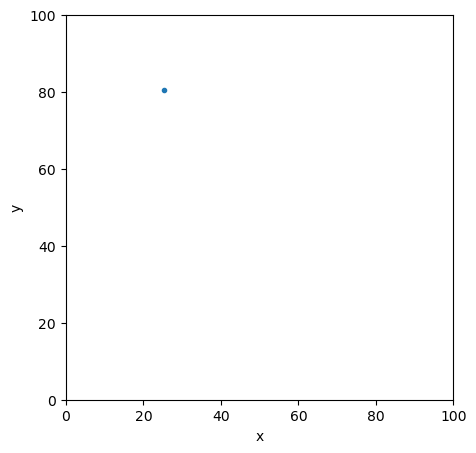

In [85]:
plt.figure(figsize=(5,5))
plt.scatter(parts1.x[:,0],parts1.x[:,1],marker='.')
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('x')
plt.ylabel('y')

In [86]:
parts1.get_kernel()
parts1.get_rho()
parts1.get_pot()

In [87]:
#parts1.v,parts1.x,parts1.m

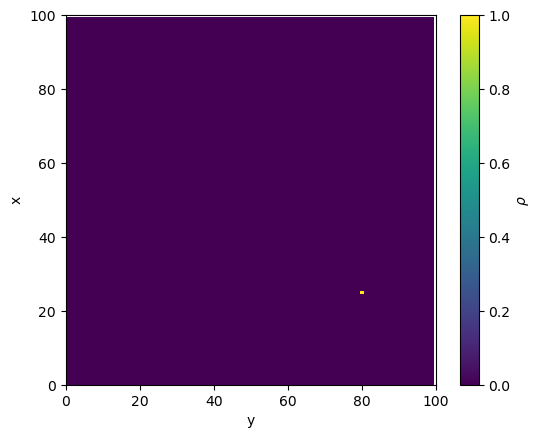

In [88]:
plt.imshow(parts1.rho)
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar(label=r'$\rho$')

In [89]:
parts1.x

array([[25.42672888, 80.47733782]])

Let's take some step with take_step and $dt=0.02$.

In [90]:
nstep=1000
xn=np.zeros((nstep,parts1.npart,2))
vn=np.zeros((nstep,parts1.npart,2))
t=0
tp=[]
for i in range(0,nstep):
    #for j in range(osamp):
    parts1.take_step(dt=0.002)
    t+=0.002
    tp.append(t)
    xn[i]=parts1.x
    vn[i]=parts1.v

Text(0.5, 0, 'time')

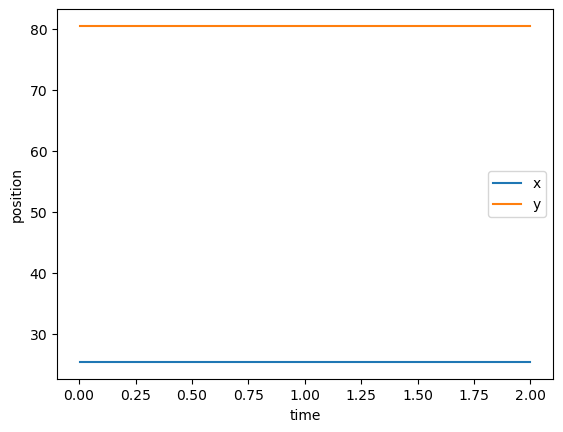

In [129]:
plt.plot(tp,xn[:,0,0],label='x')
plt.plot(tp,xn[:,0,1],label='y')
plt.legend()
plt.ylabel('position')
plt.xlabel('time')

Now I'm defining two particles in a circular orbit. Then I will pu them in the positions $(30,50)$ and $(70,50)$ with the same mass of 1 in a grid  $[0,100]\times[0,100]$. Using classical mechanics we can probe for a two body system in a circular orbit we have an angular velocity of $\omega=\sqrt{\frac{G(m_{1}+m_{2})}{(r_{1}+r_{2})^{3}}}$, with $r_{i}$ the distances to the center of mass, then as they have the same mass, the distance is the same, and the tangential velocity is $v_{t}=\omega r_{1}$. As the particles are at the same distance in y, we can set the initial velocities as $(0,-v_{t})$ and $(0,v_{t})$ to have circular orbit (we are taking G=1 for now).  

In [117]:
parts2=particles(npart=2,n=100,soft=2,periodic=True)

In [118]:
parts2.x=np.array([[30.,50.],[70.,50.]])

In [119]:
parts2.m=np.ones(parts2.npart)*np.array([1,1])

In [120]:
vcirc=np.sqrt(np.sum(parts2.m)/(40**3))*20
parts2.v=np.array([[0.,-vcirc],[0.,vcirc]])

In [121]:
vcirc

0.11180339887498948

In [122]:
parts2.m

array([1., 1.])

In [123]:
parts2.get_kernel()
parts2.get_rho()
parts2.get_pot()

Let's take some steps to see the orbit

In [124]:
osamp=100

In [125]:
nstep=1000
xn2=np.zeros((nstep,parts2.npart,2))
vn2=np.zeros((nstep,parts2.npart,2))
t=0
tp2=[]
for i in range(0,nstep):
    for j in range(osamp):
        parts2.take_step(dt=0.03)
        t+=0.03
    tp2.append(t)
    xn2[i]=parts2.x
    vn2[i]=parts2.v
    #print(xn2[i],vn2[i],i)

In [126]:
x2=xn2[:,:,0]
y2=xn2[:,:,1]

We can see that they follow a circular orbit:

(0.0, 100.0)

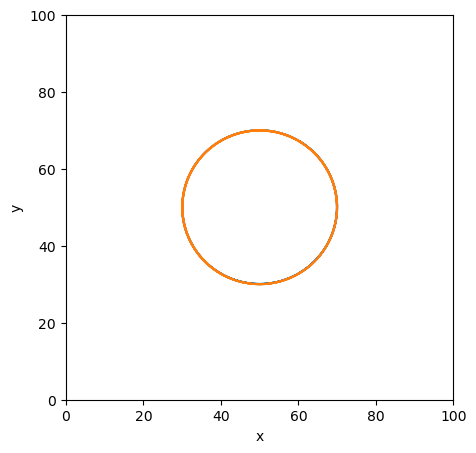

In [127]:
plt.figure(figsize=(5,5))
plt.plot(x2[:,0],y2[:,0],'-')
plt.plot(x2[:,1],y2[:,1],'-')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,100)
plt.ylim(0,100)

Let's save an animation as binary.gif.

In [11]:
%matplotlib notebook

<IPython.core.display.Javascript object>


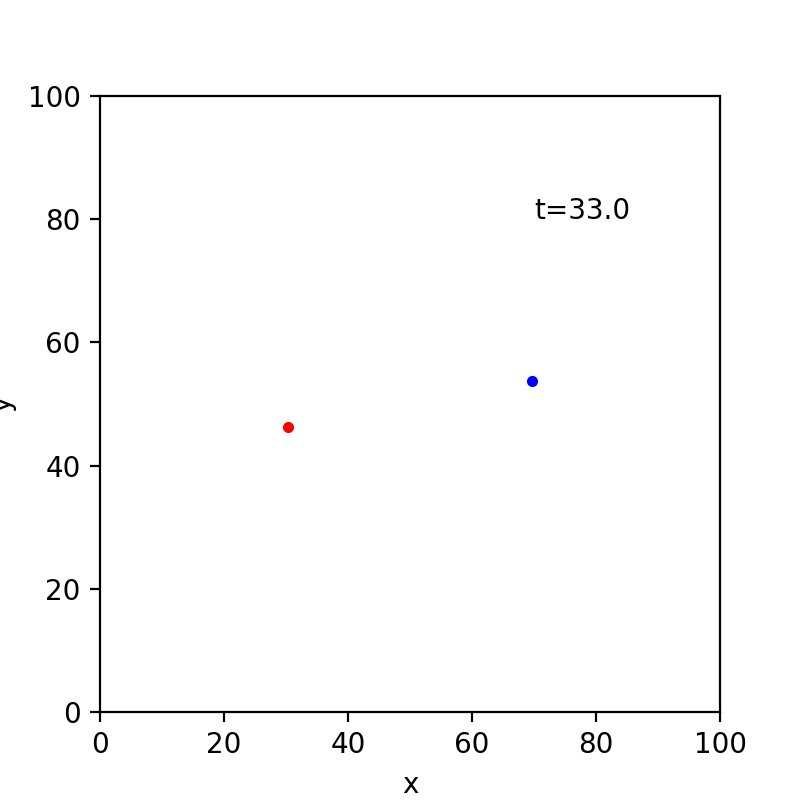

In [187]:
fig,ax = plt.subplots(figsize=(4,4))

def animate(i):
    ax.clear()
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    #line, = ax.plot(x1[0:i], y1[0:i], color = 'blue', lw=1)
    #line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
    #line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
    point1, = ax.plot(x2[:,1][i],y2[:,1][i], marker='.', color='blue')
    point2, = ax.plot(x2[:,0][i],y2[:,0][i], marker='.', color='red')
    ax.text(70,80,'t='+str(round(tp2[i],3)))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.legend()
    #print(i)
    #point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
    return point1, point2,# point3,
        
ani = FuncAnimation(fig, animate, frames=1000, blit=True, repeat=True, interval=100)    
ani.save("binary.gif", dpi=300, writer=PillowWriter(fps=25))
plt.show()

Let's take 200000 particles and see the evolution of energy with time. I also defined the function potential_e and kinetic_e to obtain the total potential and kinetic energy for every particle. Also I conserved ics_gauss method from Professor Sievers' code to generate a gaussian distribution of particles.

In [4]:
def potential_e(rho,pot):
    return -np.sum(rho*pot)
def kinetic_e(m,v):
    return 0.5*np.sum(m*((v.T)**2))

Let's do the non-periodic case first, with a Gaussian distribution and random velocities from a normal distribution. 

In [5]:
(np.array([2,3])*((np.array([[2,3],[5,4]]).T)**2))

array([[ 8, 75],
       [18, 48]])

In [6]:
partsn=particles(npart=200000,n=100,soft=2,periodic=False)

In [7]:
partsn.ics_gauss()

In [8]:
partsn.v=np.random.randn(partsn.npart,2)*50

In [9]:
osamp=5
nstep=400
xnn=np.zeros((nstep+1,partsn.npart,2))
vnn=np.zeros((nstep+1,partsn.npart,2))
poten=np.zeros(nstep+1)
kinen=np.zeros(nstep+1)
t=0
tp=np.zeros(nstep+1)
partsn.get_kernel()
partsn.get_rho()
partsn.get_pot()
poten[0]=potential_e(partsn.rho.copy(),partsn.pot.copy())
kinen[0]=kinetic_e(partsn.m.copy(),partsn.v.copy())
xnn[0]=partsn.x.copy()
vnn[0]=partsn.v.copy()

In [ ]:
for i in range(0,nstep):
    t1=time.time()
    for j in range(osamp):
        partsn.take_step(dt=0.02)
        t+=0.02
    xnn[i+1]=partsn.x
    vnn[i+1]=partsn.v
    tp[i+1]=t
    partsn.get_kernel()
    partsn.get_rho()
    partsn.get_pot()
    poten[i+1]=potential_e(partsn.rho,partsn.pot)
    kinen[i+1]=kinetic_e(partsn.m,partsn.v)
    #print(poten[i+1],kinen[i+1],i,time.time()-t1)

<IPython.core.display.Javascript object>


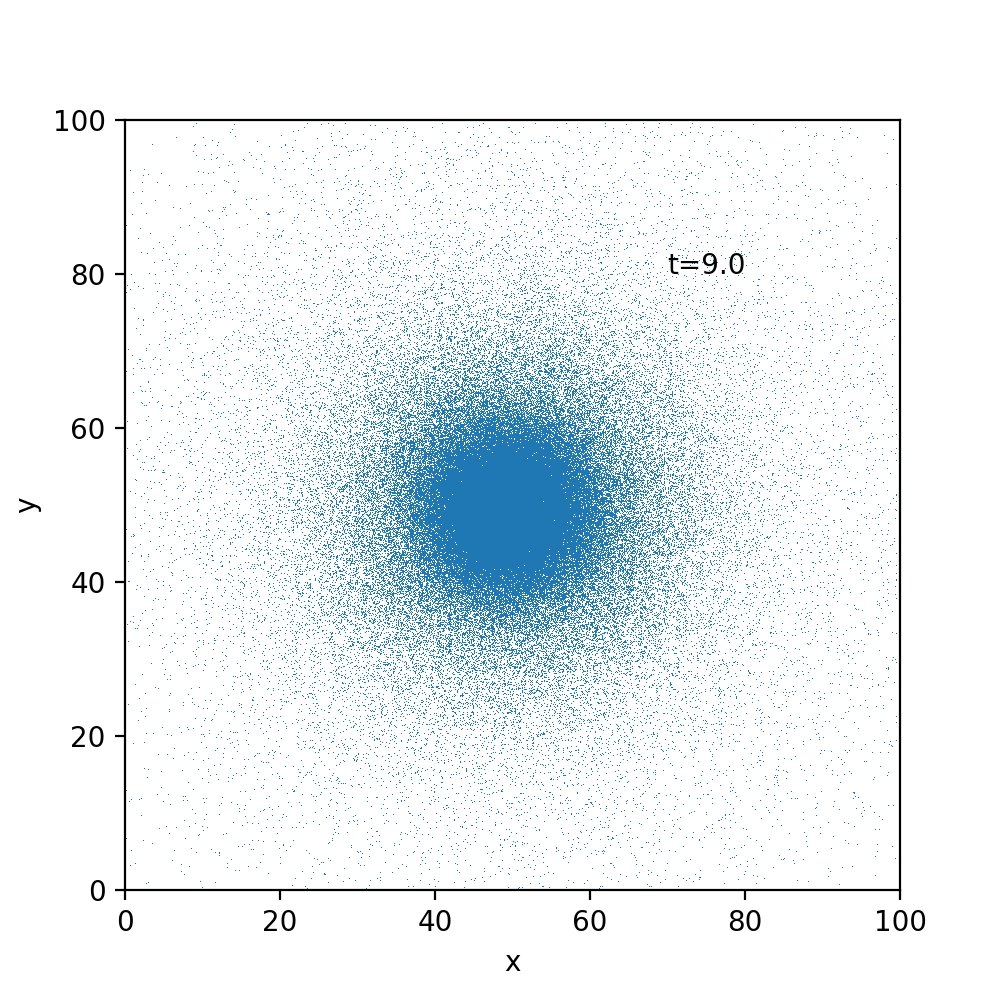

In [42]:
fig,ax = plt.subplots(figsize=(5,5))
nm=50
def animate(i):
    ax.clear()
    ax.set_xlim(50-nm,50+nm)
    ax.set_ylim(50-nm,50+nm)
    #line, = ax.plot(x1[0:i], y1[0:i], color = 'blue', lw=1)
    #line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
    #line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
    point1, = ax.plot(xnn[i][:,0],xnn[i][:,1],',',markersize=2)
    ax.text(70,80,'t='+str(round(tp[i],3)))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #point2, = ax.plot(x2[:,0][i],y2[:,0][i], marker='.', color='red')
    #ax.text()
    #print(i)
    #point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
    return point1, #point2,# point3,
        
ani = FuncAnimation(fig, animate, frames=400, blit=True, repeat=True, interval=100)    
ani.save("npart_no_p.gif", dpi=300, writer=PillowWriter(fps=5))
plt.show()

<IPython.core.display.Javascript object>


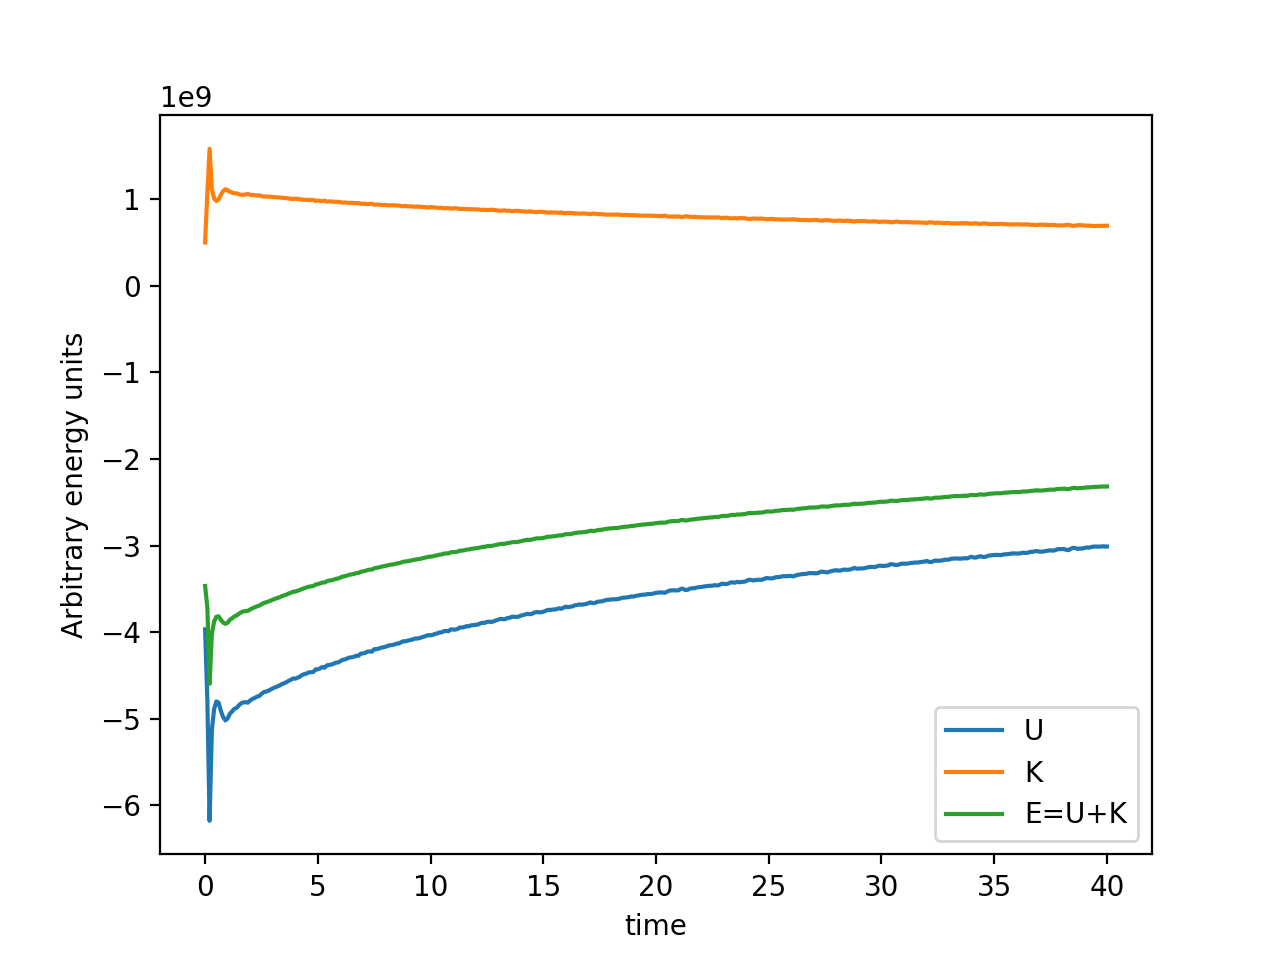

In [43]:
plt.plot(tp,poten,label='U')
plt.plot(tp,kinen,label='K')
plt.plot(tp,kinen+poten,label='E=U+K')
plt.xlabel('time')
plt.ylabel('Arbitrary energy units')
plt.legend()

<IPython.core.display.Javascript object>


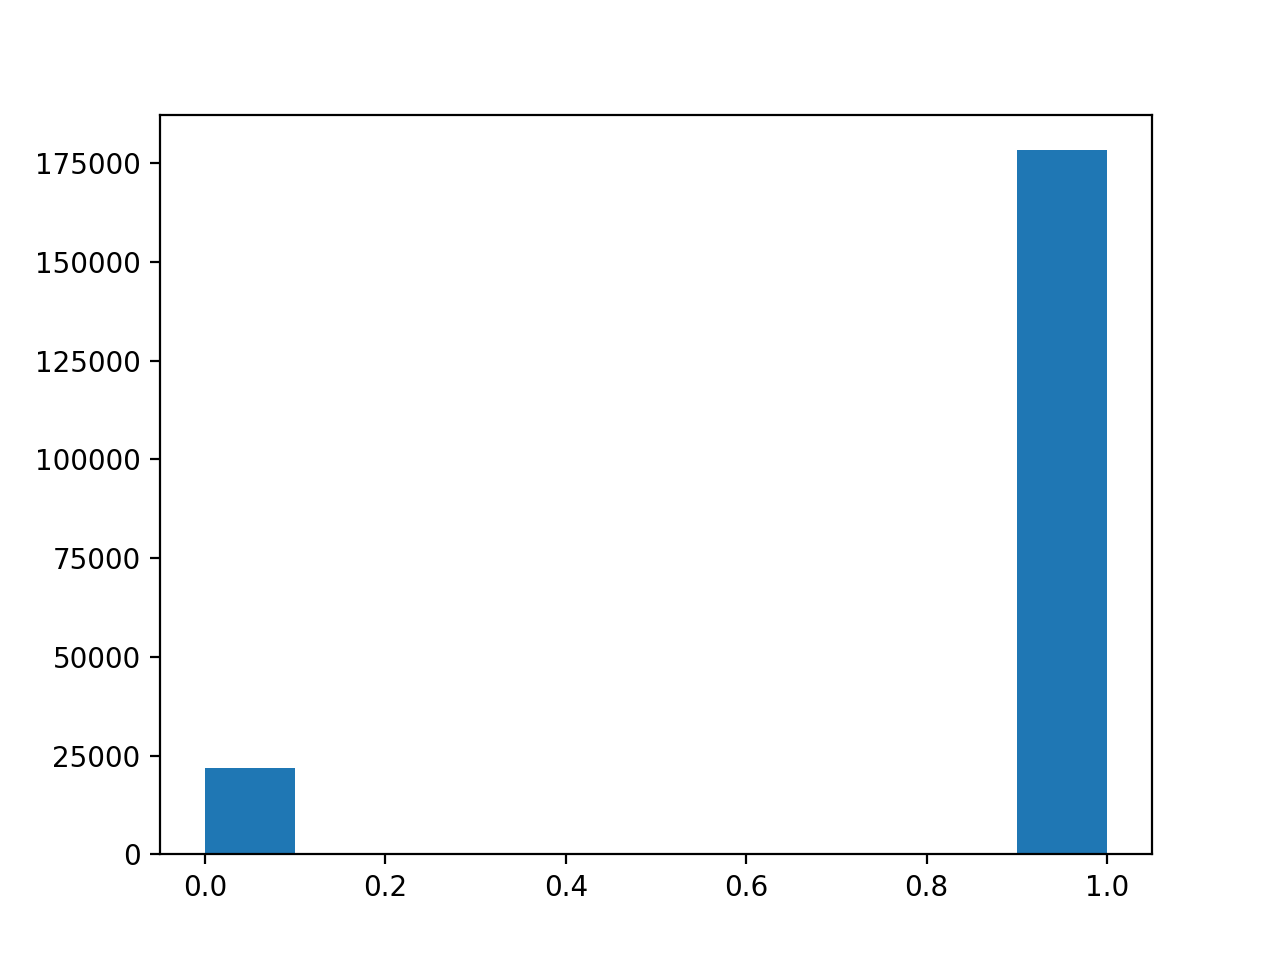

(array([ 21798.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 178202.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

In [44]:
plt.hist(partsn.m)

Let's take the periodic case:

In [92]:
partsp=particles(npart=200000,n=100,soft=2,periodic=True)

In [93]:
x0=xnn[0].copy()
v0=vnn[0].copy()

In [33]:
partsp.x=x0

In [34]:
partsp.v=v0

In [35]:
partsp.m=np.ones(partsp.npart)

In [36]:
osamp=5
nstep=400
xpp=np.zeros((nstep+1,partsp.npart,2))
vpp=np.zeros((nstep+1,partsp.npart,2))
potep=np.zeros(nstep+1)
kinep=np.zeros(nstep+1)
t=0
tpp=np.zeros(nstep+1)
partsp.get_kernel()
partsp.get_rho()
partsp.get_pot()
potep[0]=potential_e(partsp.rho.copy(),partsp.pot.copy())
kinep[0]=kinetic_e(partsp.m.copy(),partsp.v.copy())
xpp[0]=partsp.x.copy()
vpp[0]=partsp.v.copy()

In [ ]:
for i in range(0,nstep):
    t1=time.time()
    for j in range(osamp):
        partsp.take_step(dt=0.02)
        t+=0.02
    xpp[i+1]=partsp.x
    vpp[i+1]=partsp.v
    tpp[i+1]=t
    partsp.get_kernel()
    partsp.get_rho()
    partsp.get_pot()
    potep[i+1]=potential_e(partsp.rho,partsp.pot)
    kinep[i+1]=kinetic_e(partsp.m,partsp.v)
    #print(potep[i+1],kinep[i+1],i,time.time()-t1)

<IPython.core.display.Javascript object>


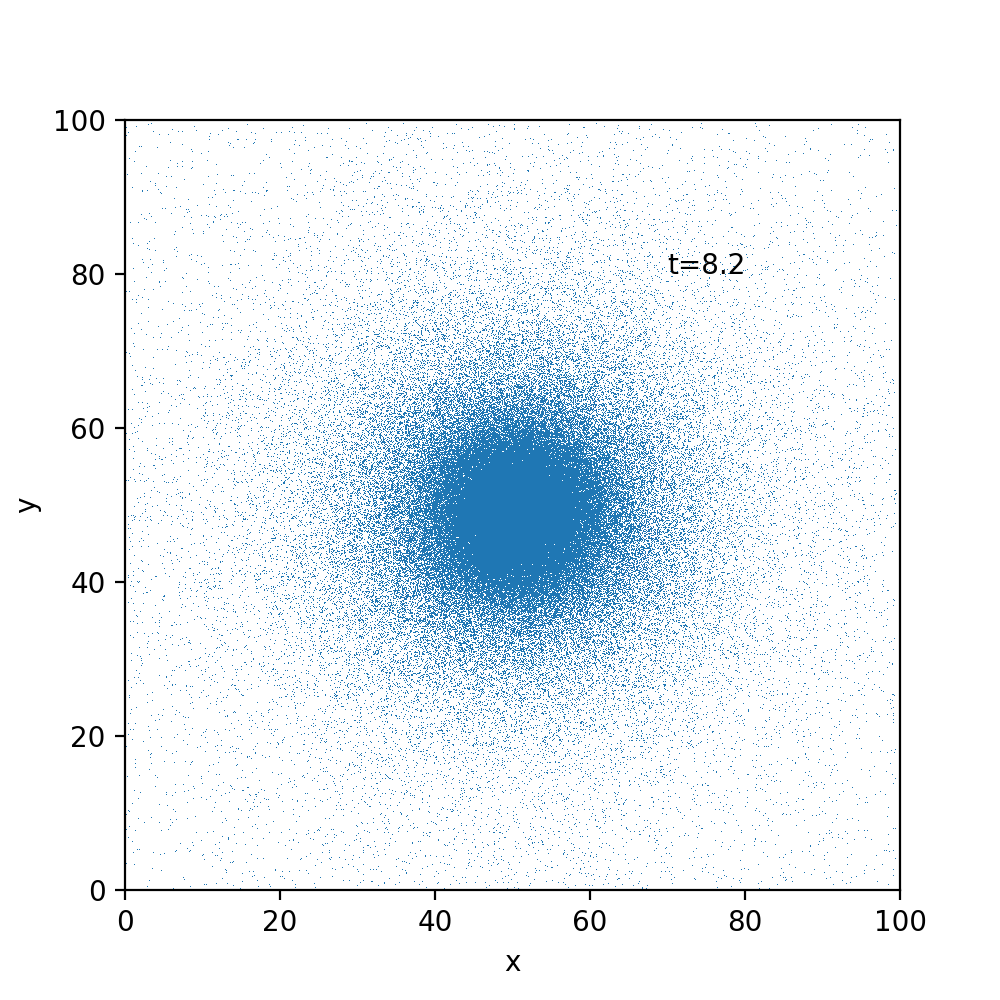

In [40]:
fig,ax = plt.subplots(figsize=(5,5))
nm=50
def animate(i):
    ax.clear()
    ax.set_xlim(50-nm,50+nm)
    ax.set_ylim(50-nm,50+nm)
    #line, = ax.plot(x1[0:i], y1[0:i], color = 'blue', lw=1)
    #line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
    #line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
    point1, = ax.plot(xpp[i][:,0],xpp[i][:,1],',',markersize=2)
    ax.text(70,80,'t='+str(round(tpp[i],3)))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #point2, = ax.plot(x2[:,0][i],y2[:,0][i], marker='.', color='red')
    #ax.text()
    #print(i)
    #point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
    return point1, #point2,# point3,
        
ani = FuncAnimation(fig, animate, frames=400, blit=True, repeat=True, interval=100)    
ani.save("npart_p.gif", dpi=300, writer=PillowWriter(fps=5))
plt.show()

In [158]:
%matplotlib auto

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


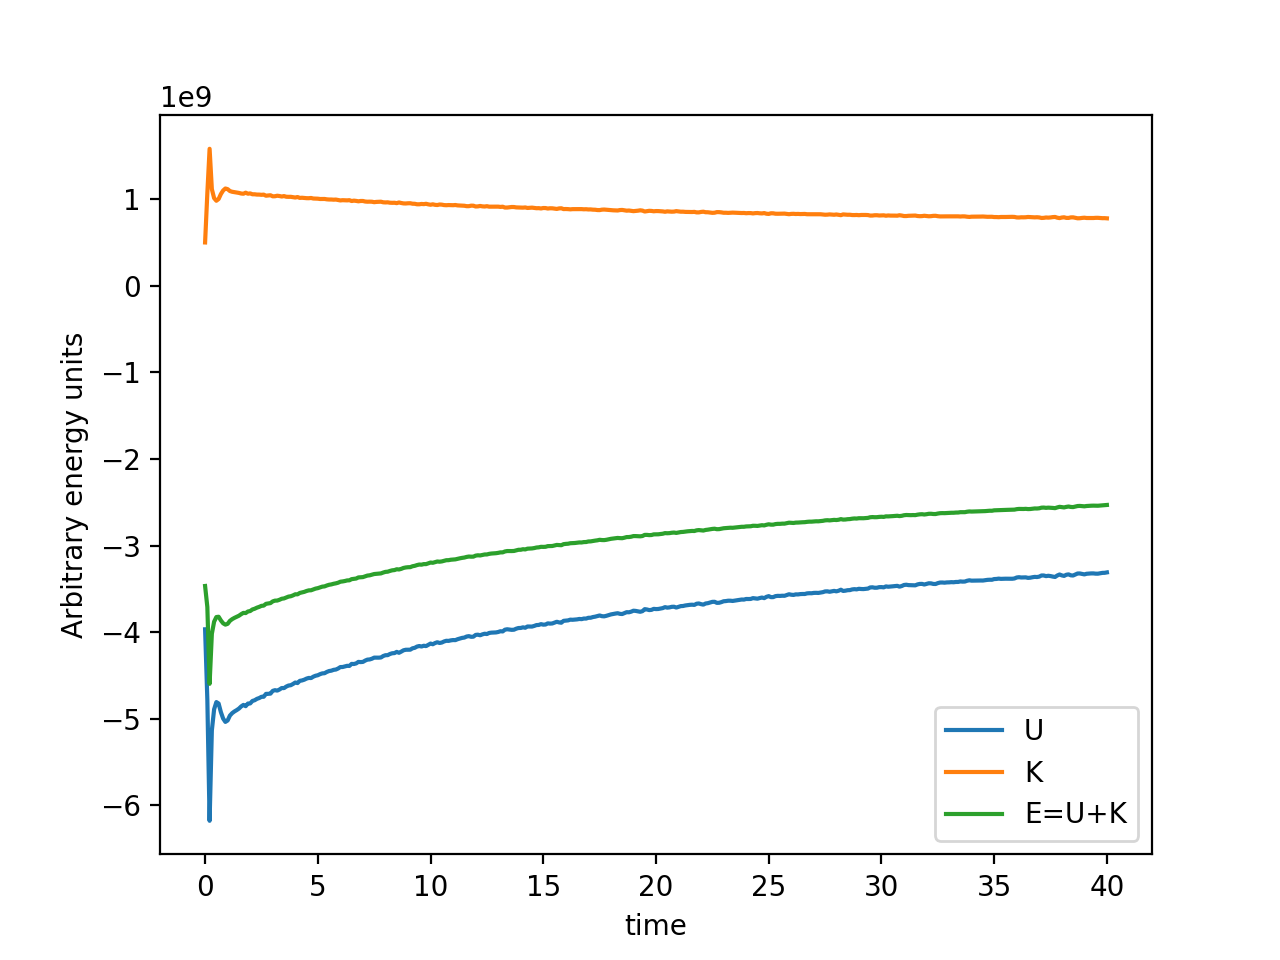

In [46]:
plt.plot(tpp,potep,label='U')
plt.plot(tpp,kinep,label='K')
plt.plot(tpp,kinep+potep,label='E=U+K')
plt.xlabel('time')
plt.ylabel('Arbitrary energy units')
plt.legend()

<IPython.core.display.Javascript object>


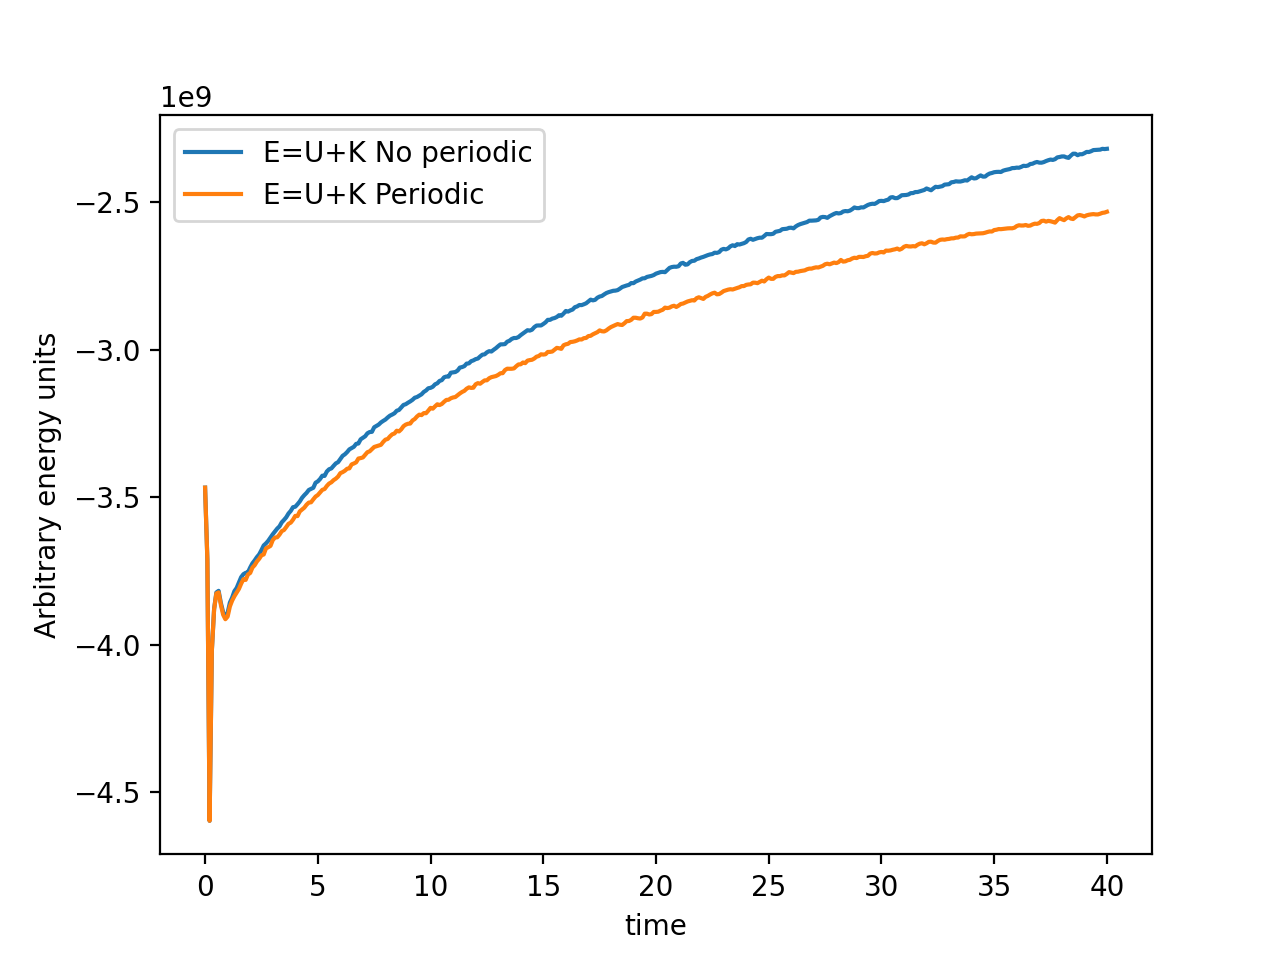

In [47]:
plt.plot(tp,kinen+poten,label='E=U+K No periodic')
plt.plot(tpp,kinep+potep,label='E=U+K Periodic')
plt.xlabel('time')
plt.ylabel('Arbitrary energy units')
plt.legend()

We can see that the energy for both cases started similar and have an asymptotic behavior, however, for the periodic case it seems that the energy is becoming constant faster than the non-periodic case.

Let's do the same but using the RK4 step.

In [139]:
parts4n=particles(npart=200000,n=100,soft=2,periodic=False)

I will take the same initial conditions as before.

In [140]:
parts4n.x=xnn[0].copy()

In [141]:
parts4n.v=vnn[0].copy()

In [142]:
parts4n.m=np.ones(200000)

I'm going to take 100 steps with a timestep of 0.08 in order to have the same work for the same amount of time as in the case with take_step. This because take_step_rk4 have to obtain the forces 4 times to obtain the k factors.

In [143]:
nstep=100
xnk=np.zeros((nstep+1,parts4n.npart,2))
vnk=np.zeros((nstep+1,parts4n.npart,2))
potenk=np.zeros(nstep+1)
kinenk=np.zeros(nstep+1)
t=0
tpk=np.zeros(nstep+1)
parts4n.get_kernel()
parts4n.get_rho()
parts4n.get_pot()
potenk[0]=potential_e(parts4n.rho.copy(),parts4n.pot.copy())
kinenk[0]=kinetic_e(parts4n.m.copy(),parts4n.v.copy())
xnk[0]=parts4n.x.copy()
vnk[0]=parts4n.v.copy()

In [ ]:
for i in range(0,nstep):
    t1=time.time()
    for j in range(osamp):
        parts4n.take_step_rk4(dt=0.08)
        t+=0.08
    xnk[i+1]=parts4n.x
    vnk[i+1]=parts4n.v
    tpk[i+1]=t
    parts4n.get_kernel()
    parts4n.get_rho()
    parts4n.get_pot()
    potenk[i+1]=potential_e(parts4n.rho,parts4n.pot)
    kinenk[i+1]=kinetic_e(parts4n.m,parts4n.v)
    #print(potenk[i+1],kinenk[i+1],i,time.time()-t1)

<IPython.core.display.Javascript object>


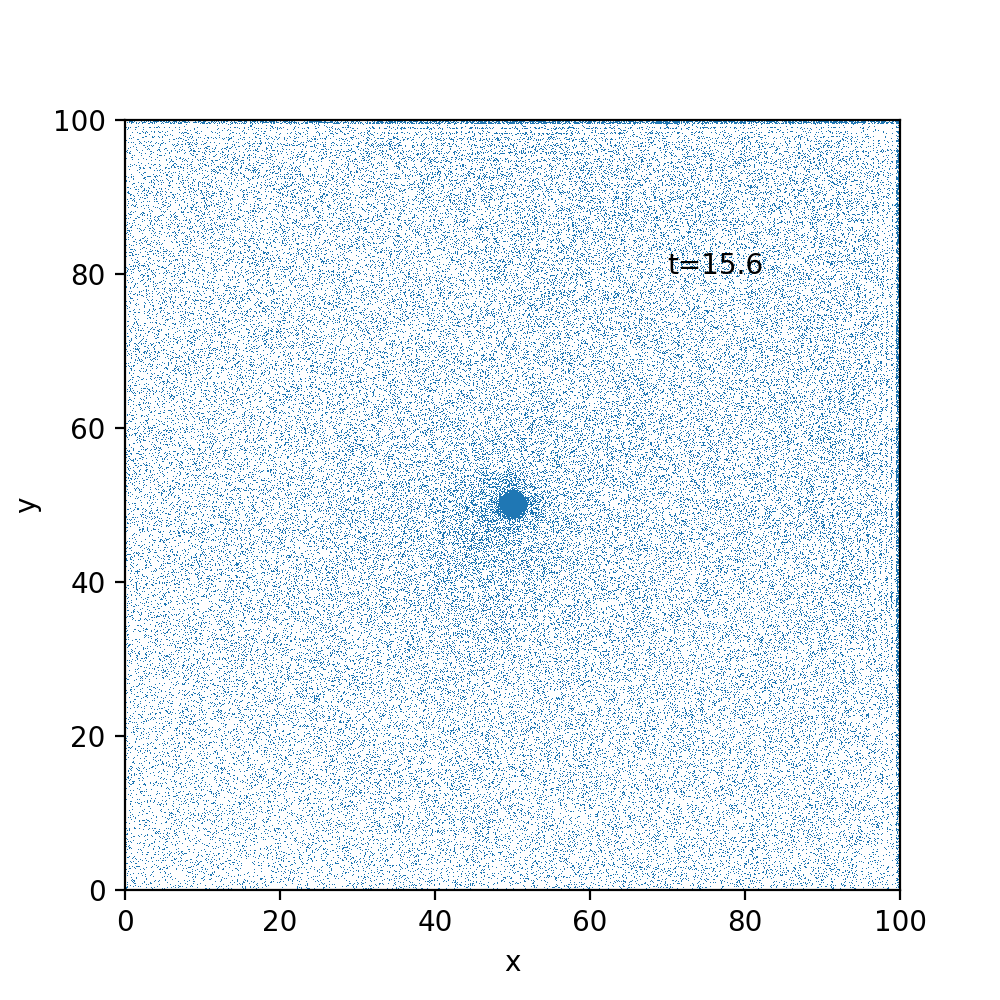

In [148]:
fig,ax = plt.subplots(figsize=(5,5))
nm=50
def animate(i):
    ax.clear()
    ax.set_xlim(50-nm,50+nm)
    ax.set_ylim(50-nm,50+nm)
    #line, = ax.plot(x1[0:i], y1[0:i], color = 'blue', lw=1)
    #line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
    #line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
    point1, = ax.plot(xnk[i][:,0],xnk[i][:,1],',',markersize=2)
    ax.text(70,80,'t='+str(round(tpk[i],3)))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #point2, = ax.plot(x2[:,0][i],y2[:,0][i], marker='.', color='red')
    #ax.text()
    #print(i)
    #point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
    return point1, #point2,# point3,
        
ani = FuncAnimation(fig, animate, frames=100, blit=True, repeat=True, interval=25)    
ani.save("rk4_nonperiodic.gif", dpi=300, writer=PillowWriter(fps=3))
plt.show()

<IPython.core.display.Javascript object>


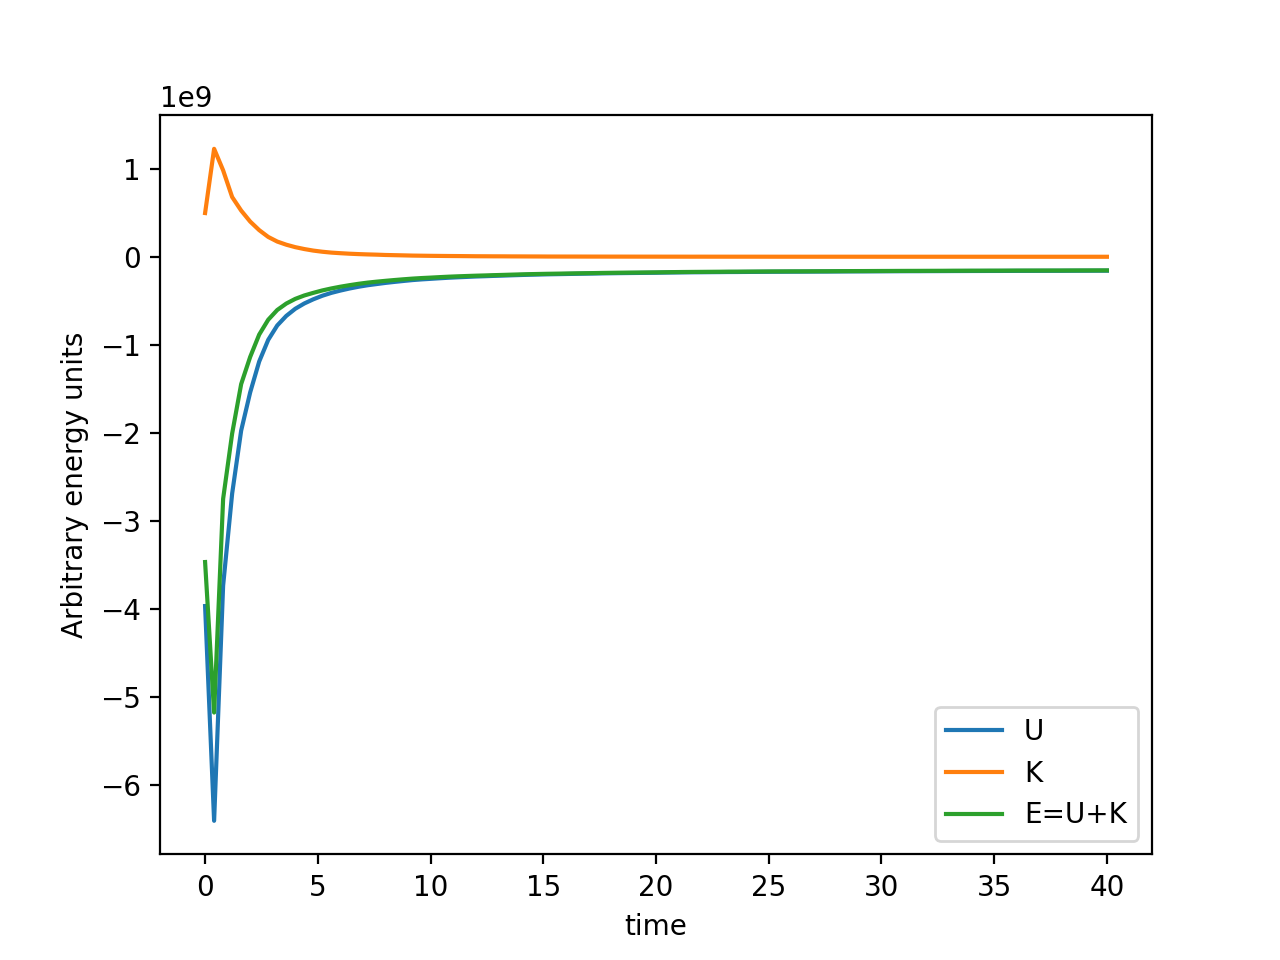

In [149]:
plt.plot(tpk,potenk,label='U')
plt.plot(tpk,kinenk,label='K')
plt.plot(tpk,kinenk+potenk,label='E=U+K')
plt.xlabel('time')
plt.ylabel('Arbitrary energy units')
plt.legend()

Finally, the periodic case for the rk4 integrator.

In [128]:
parts4p=particles(npart=200000,n=100,soft=2,periodic=True)

In [129]:
parts4p.x=xnn[0].copy()

In [130]:
parts4p.v=vnn[0].copy()

In [131]:
parts4p.m=np.ones(200000)

In [132]:
nstep=100
xpk=np.zeros((nstep+1,parts4p.npart,2))
vpk=np.zeros((nstep+1,parts4p.npart,2))
potepk=np.zeros(nstep+1)
kinepk=np.zeros(nstep+1)
t=0
tppk=np.zeros(nstep+1)
parts4p.get_kernel()
parts4p.get_rho()
parts4p.get_pot()
potepk[0]=potential_e(parts4p.rho.copy(),parts4p.pot.copy())
kinepk[0]=kinetic_e(parts4p.m.copy(),parts4p.v.copy())
xpk[0]=parts4p.x.copy()
vpk[0]=parts4p.v.copy()

In [ ]:
for i in range(0,nstep):
    t1=time.time()
    for j in range(osamp):
        parts4p.take_step_rk4(dt=0.08)
        t+=0.08
    xpk[i+1]=parts4p.x
    vpk[i+1]=parts4p.v
    tppk[i+1]=t
    parts4p.get_kernel()
    parts4p.get_rho()
    parts4p.get_pot()
    potepk[i+1]=potential_e(parts4p.rho,parts4p.pot)
    kinepk[i+1]=kinetic_e(parts4p.m,parts4p.v)
    #print(potepk[i+1],kinepk[i+1],i,time.time()-t1)

<IPython.core.display.Javascript object>


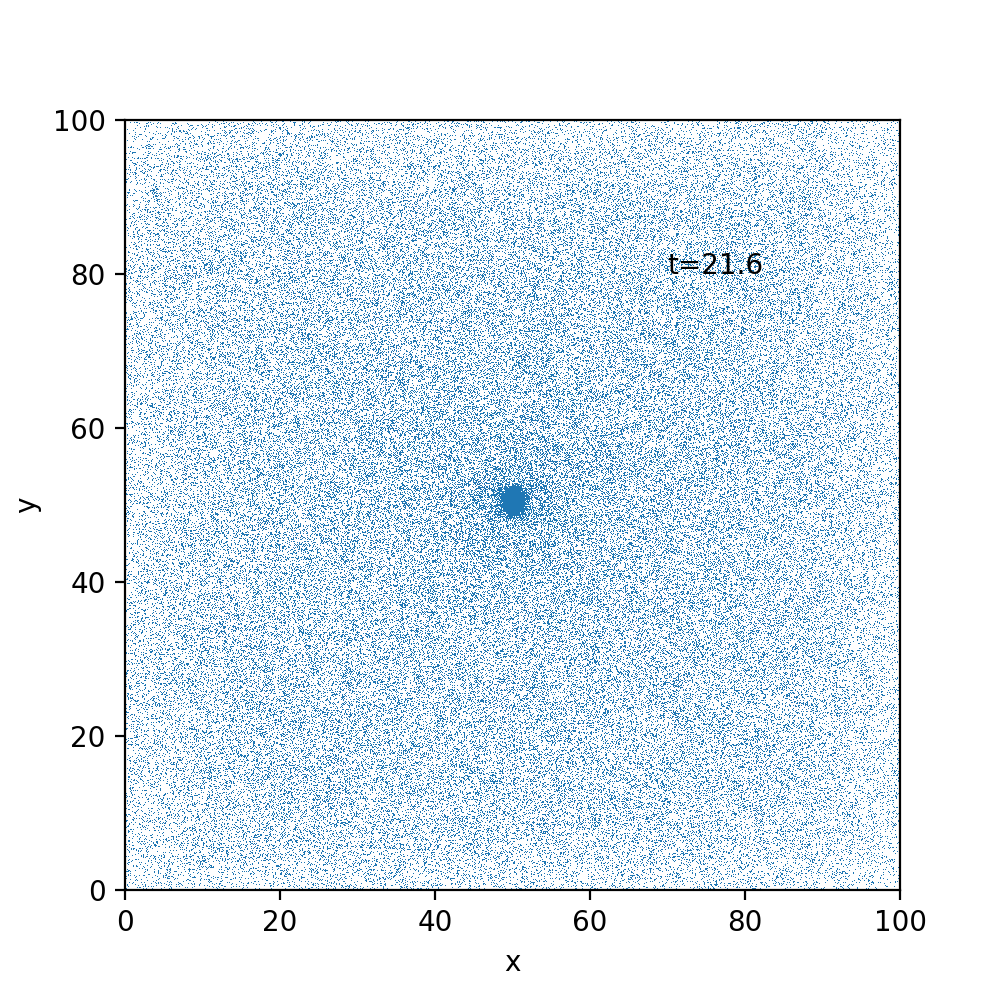

In [136]:
fig,ax = plt.subplots(figsize=(5,5))
nm=50
def animate(i):
    ax.clear()
    ax.set_xlim(50-nm,50+nm)
    ax.set_ylim(50-nm,50+nm)
    #line, = ax.plot(x1[0:i], y1[0:i], color = 'blue', lw=1)
    #line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
    #line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
    point1, = ax.plot(xpk[i][:,0],xpk[i][:,1],',',markersize=2)
    ax.text(70,80,'t='+str(round(tppk[i],3)))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #point2, = ax.plot(x2[:,0][i],y2[:,0][i], marker='.', color='red')
    #ax.text()
    #print(i)
    #point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
    return point1, #point2,# point3,
        
ani = FuncAnimation(fig, animate, frames=100, blit=True, repeat=True, interval=25)    
ani.save("rk4_periodic.gif", dpi=300, writer=PillowWriter(fps=3))
plt.show()

<IPython.core.display.Javascript object>


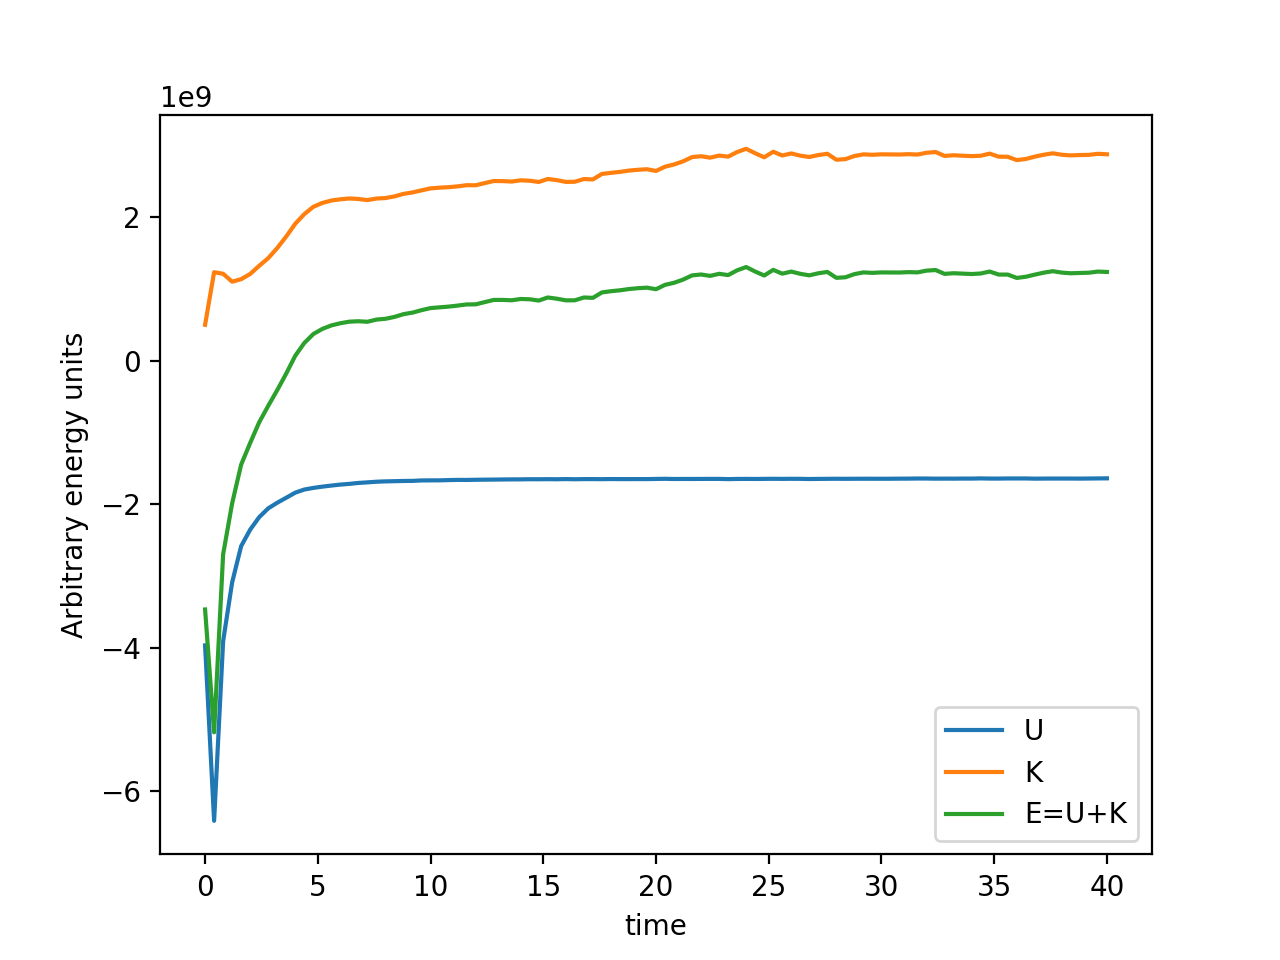

In [138]:
plt.plot(tppk,potepk,label='U')
plt.plot(tppk,kinepk,label='K')
plt.plot(tppk,kinepk+potepk,label='E=U+K')
plt.xlabel('time')
plt.ylabel('Arbitrary energy units')
plt.legend()

<IPython.core.display.Javascript object>


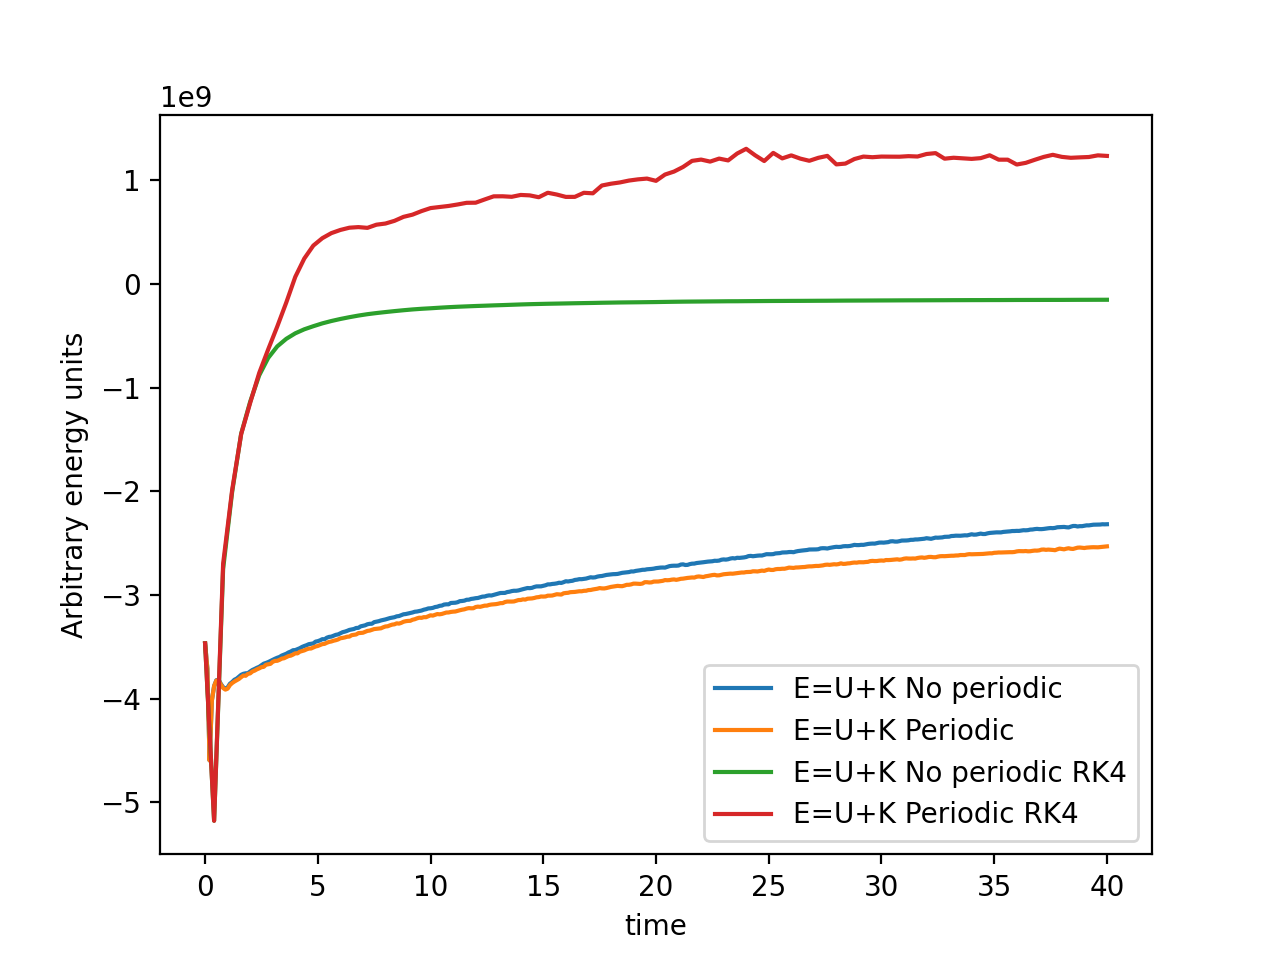

In [150]:
plt.plot(tp,kinen+poten,label='E=U+K No periodic')
plt.plot(tpp,kinep+potep,label='E=U+K Periodic')
plt.plot(tpk,kinenk+potenk,label='E=U+K No periodic RK4')
plt.plot(tppk,kinepk+potepk,label='E=U+K Periodic RK4')
plt.xlabel('time')
plt.ylabel('Arbitrary energy units')
plt.legend()

We can see that for the non-periodic RK4 case reaches a constat value of the energy faster than the other cases, while the periodic case RK4 seems to achieve a value almost constant but it is more unstable. Although the cases without RK4 seem to be asymptotic to a constant energy value, in the considered time they didn't reach a constant value. Then, the non-periodic case with RK4 seems to preserves the energy better.

Names of the animations:

npart_no_p.gif for non-periodic with take_step

npart_p.gif for periodic with take_step

rk4_nonperiodic.gif for non-periodic with take_step_rk4

rk4_periodic.gif for periodic with take_step_rk4

## Application to $\omega$ Cen.

I wanted to use the code for an astrophysical problem. One of the misteries about black holes that we have not been able to detect an intermediate mass black hole (IMBH) of typical masses of about $10^{3}-10^{6}M_{\odot}$. Some people have proposed that some globular clusters can contain an IMBH in the center, then, a way to describe if they are there is comparing dynamical models with the velocity dispersions observed in the stars of the cluster.

I started defining a constant $G$ with useful units for the problem. One option could be take $G=39.478\ AU^{3}\ yr^{-2}\ M_{\odot}^{-1}$. However, we can take units of $dpc=10^{-1}\ pc$ for distance and $hyr=10^{2}\ yr$ in order to have computations in units that are often used in stellar clusters. 

In [ ]:
G=39.478*((u.au.to(u.dpc,1))**3)*((u.yr.to(u.hyr,1))**-2) #dpc^3 hyr^-2 M_sun^-1

In [58]:
G

4.498624490068909e-08

The value obtained was $4.4986\times10^{-8}\ dpc^{3}\ hyr^{-2} M_{\odot}^{-1}$.

I chose to use the globular cluster $\omega\ Cen$. First, I need a model for the density profile, for this I started with a spherical approximation for a multi-Gaussian profile obtained from the surface brightness profile of the globular cluster. This is described for Evans et al. (2021), then I took some of their equations (6), (7), (8) and (9), an their Table 1 for the parameters obtained from the surface brightness and that form the Gaussians:

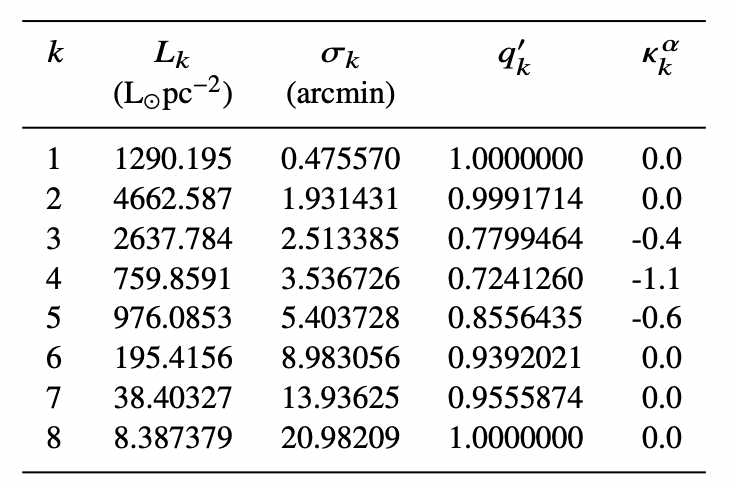

Equation (6) defined the relation between the parameters $q_{k}$ and the inclination of the cluster to project the density surface brightness profile and obtain a 3D mass density profile. An estimation for inclination for $\omega\ Cen$ is $i=50^{o}$ (e.g. Watkins et al. 2013):

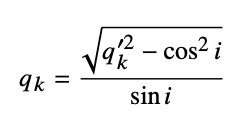

Equation (7) defines the 3D mass density in cylindrical coordinates:

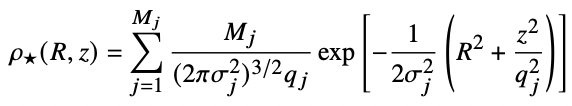

Equation (8) relates $M_{j}$ with the parameters obtained for $L_{j}$ in the Table ($k=j$). We could consider a constant mass-to-light ratio $\Upsilon_{*}=2.6\ M_{\odot}/L_{\odot}$ (e.g. near to the value from Watkins et al. 2013):

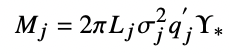

Finally equation (9) is an spherical approximation for the density distribution. I will use this distribution in order to simplify the problem an just use the 2D projection for the N-body solver.

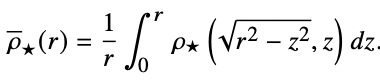

Below, I defined the parameters from the table.

In [151]:
surf_lum=np.array([1290.195, 
4662.587, 
2637.784,  
759.8591,  
976.0853,  
195.4156,  
38.40327,  
8.387379])  

sig_lum=np.array([0.475570,  
1.931431,  
2.513385,  
3.536726,  
5.403728,  
8.983056,  
13.93625,  
20.98209])*60 #arcsecs

qobs_lum=np.array([0.99999999, 
0.9991714, 
0.7799464, 
0.7241260, 
0.8556435, 
0.9392021, 
0.9555874,
0.99999999])

The variable rad is a range in $pc$ for obtaining the profile and D is the distance to the cluster to change from arcsecs to $pc$ using $R[pc]=R[arcsec]\pi D[kpc]/648$.

In [152]:
rad=np.linspace(0.001,100,10000)
D=5.2 #kpc

Below, I defined rho_mean1 to obtain the density from equation (9) using all the equations described above. I solved analytically the integral an put the expression in the function.

In [153]:
def rho_mean1(rad,m_l,inc):
    summ=[]
    slum=sig_lum*(np.pi*D)/(648)
    q_lum=np.sqrt((qobs_lum**2)-(np.cos(inc*np.pi/180))**2)/np.sin(inc*np.pi/180)
    for i in range(0,len(surf_lum)):
        intg=np.exp(((-rad**2)/(2*(slum[i]**2))))*np.sqrt(np.pi/2)*q_lum[i]*slum[i]*special.erfi(1j*np.sqrt(1-(q_lum[i]**2))*rad/(np.sqrt(2)*q_lum[i]*slum[i]))/(1j*np.sqrt(1-(q_lum[i]**2)))
        rr=((2*np.pi*surf_lum[i]*(slum[i]**2)*qobs_lum[i]*m_l)/(((2*np.pi*(slum[i]**2))**(3/2))*q_lum[i]))
        #print(erfi(np.sqrt((qobs_lum[i]**2)-1)*rad/(np.sqrt(2)*qobs_lum[i]*slum[i])))
        #print(np.sqrt((qobs_lum[i]**2)-1)*rad/(np.sqrt(2)*qobs_lum[i]*slum[i]))
        #print(rr)
        summ.append(intg*rr)
    return(np.real(sum(summ)/rad))

In [154]:
rhost=rho_mean1(rad,2.6,50)

Below, how the density $\rho(r)$ profile looks like. 

<IPython.core.display.Javascript object>


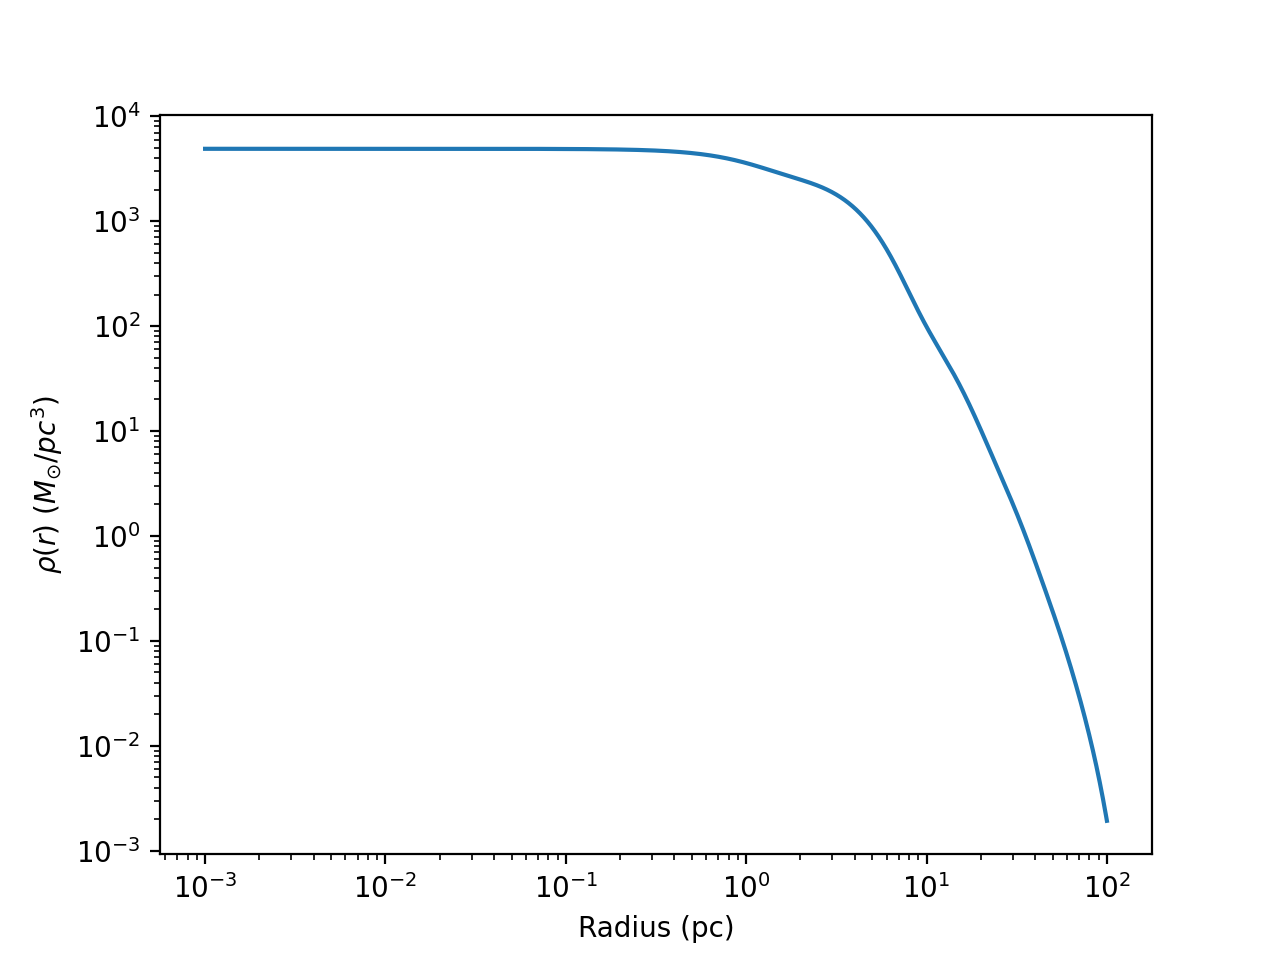

Text(0, 0.5, '$\\rho(r)$ ($M_{\\odot}/pc^{3}$)')

In [162]:
plt.loglog(rad,rho_mean1(rad,2.6,50))
plt.xlabel('Radius (pc)')
plt.ylabel(r'$\rho(r)$ ($M_{\odot}/pc^{3}$)')

I estimated an approximation for the total mass doing a rectangular integral.

In [163]:
Mt=sum([4*np.pi*(rad[k]**2)*(rhost[k])*(rad[k+1]-rad[k]) for k in range(0,len(rad)-1)])

In [164]:
Mt/1e6 

3.270412597662116

The value for the obtained total mass is similar to what was obtained in the catalogue of Baumgardt & Hilker (2018).

In order to generate points that follow this distribution we could define the number density $n(r)\approx\rho(r)/M_{t}$ and also define a Gaussian distribution as function of the radius $g(r)$ which is always larger than our $n(r)$. Then, we can generate random coordinates $(x,y,z)$ that are normally distributed according to the Gaussian, compare $n(\sqrt{x^{2}+y^{2}+z^{2}})/g(\sqrt{x^{2}+y^{2}+z^{2}})$ to accept or not the set of points, and obtain the set of points that are following $n(r)$.

In [165]:
sigma=np.sqrt(340/2)
mu=0

In [168]:
def gauss(r):
    return np.exp((-0.5*r**2)/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

Both distributions.

<IPython.core.display.Javascript object>


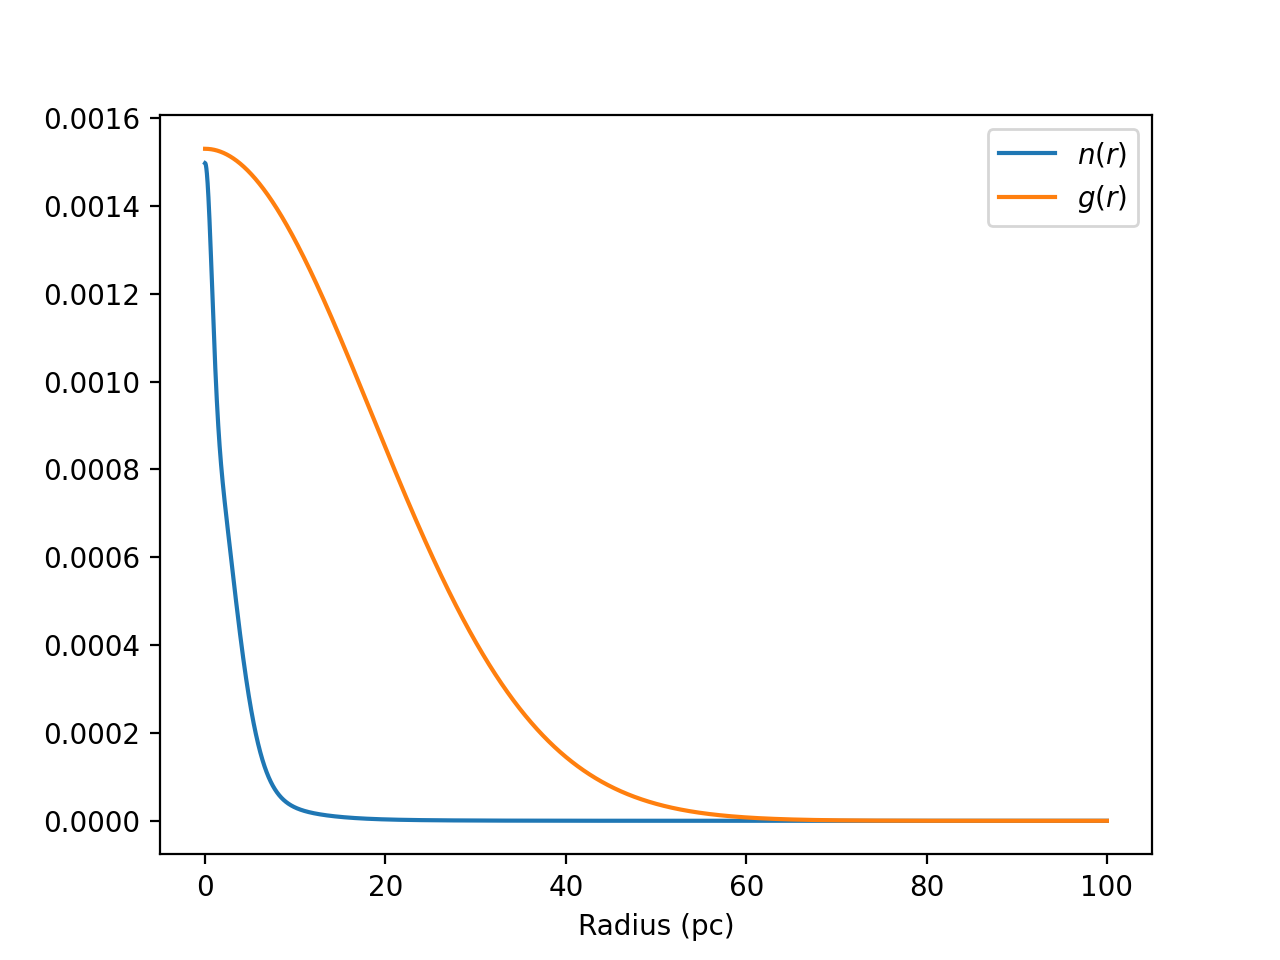

In [169]:
plt.plot(rad,rhost/Mt,label=r'$n(r)$')
plt.plot(rad,gauss(rad)*0.05,label=r'$g(r)$')
plt.xlabel('Radius (pc)')
plt.legend()
#plt.ylabel(r'$\rho(r)$ ($M_{\odot}/pc^{3}$)')

Below, the function to generate the points $(x,y,z)$.

In [170]:
def dev(N,f):
    xn=np.random.normal(mu, sigma,N)
    yn=np.random.normal(mu, sigma,N)
    zn=np.random.normal(mu, sigma,N)
    p=np.random.rand(N)
    rn=np.sqrt(xn**2+yn**2+zn**2)
    accept=p<(rho_mean1(rn,2.6,50)/Mt)/(gauss(rn)*f)
    xa=xn[accept]
    ya=yn[accept]
    za=zn[accept]
    print(len(xa)/N)
    return xa,ya,za 

In [23]:
xx,yy,zz=dev(150000000,0.05)

In [171]:
Mt/0.014

233600899.8330083

Once generated I saved the coordinates in the file xyz.txt. I just read the file because it took a lot of time to generate the values.

In [26]:
pos=open('xyz.txt','w')
for i in range(len(xx)):
    pos.write(str(xx[i])+','+str(yy[i])+','+str(zz[i])+'\n')
pos.close()

In [172]:
posr=open('xyz.txt','r')
ll=[(d.strip()).split(',') for d in posr.readlines()]
posr.close()

Let's change from $pc$ to $dpc$ to use our $G$.

In [173]:
xx=np.array([float(i[0]) for i in ll])*10 #dpc
yy=np.array([float(i[1]) for i in ll])*10
zz=np.array([float(i[2]) for i in ll])*10

Below, some plots of the distribution of the generated points.

<IPython.core.display.Javascript object>


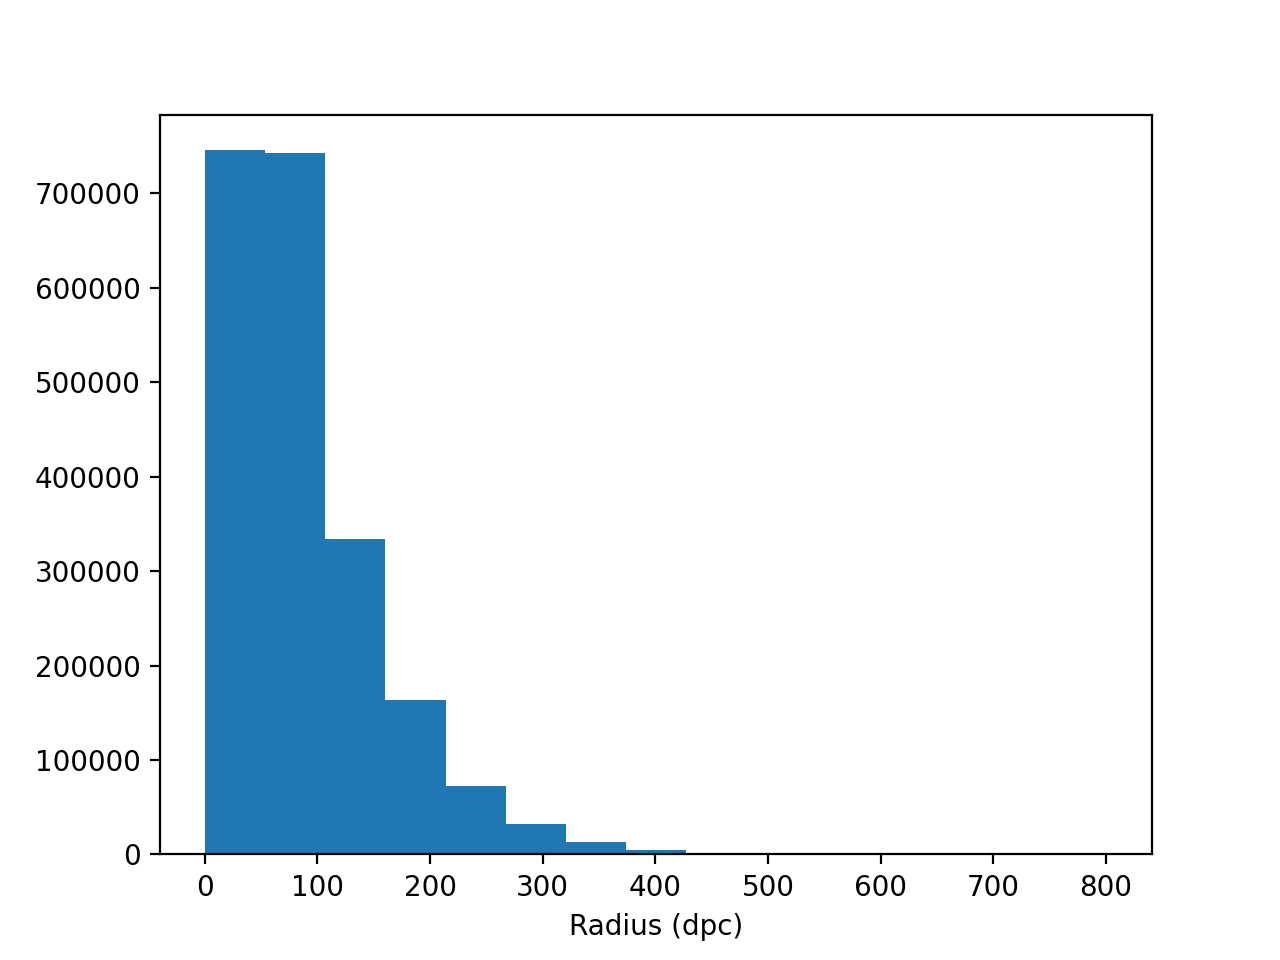

Text(0.5, 0, 'Radius (dpc)')

In [177]:
plt.hist(np.sqrt(xx**2+yy**2+zz**2),bins=15)
plt.xlabel('Radius (dpc)')
#plt.xscale('log')
#plt.yscale('log')

<IPython.core.display.Javascript object>


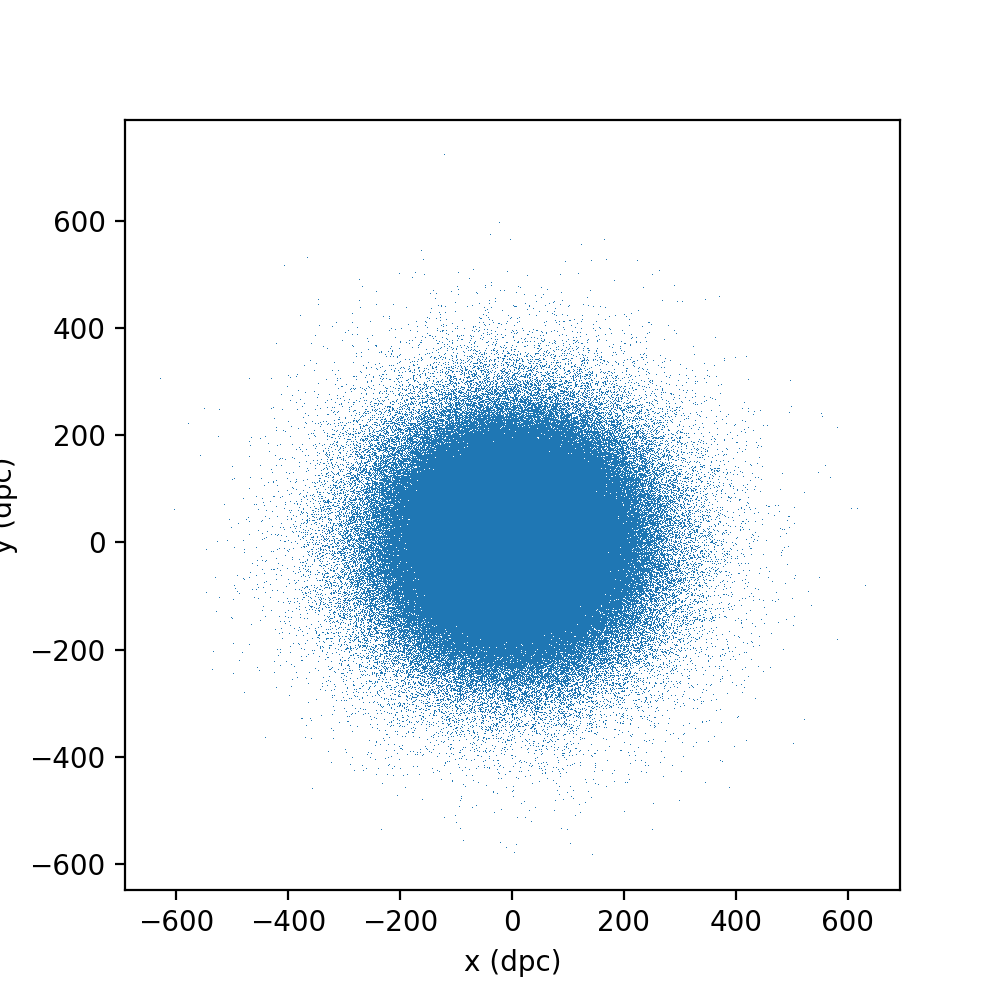

Text(0, 0.5, 'y (dpc)')

In [178]:
plt.figure(figsize=(5,5))
plt.plot(xx,yy,',')
plt.xlabel('x (dpc)')
plt.ylabel('y (dpc)')
#plt.xlim(-1,1)
#plt.ylim(-1,1)

In [179]:
min(xx),max(xx),min(yy),max(yy)

(-628.0908819155204, 630.3085783873753, -582.4651233799218, 722.129505208344)

As we will use a grid in the solver I added some points in corners that are beyond the maximum and minimum in $x$ and $y$. Also, I will be working just with $x$ and $y$ because the solver is 2D.

In [180]:
xx1=np.concatenate([xx,[0.,730.,0.,-730.,0.]])
yy1=np.concatenate([yy,[730.,0.,-730.,0.,0.]])

In [181]:
min(xx1),max(xx1),min(yy1),max(yy1)

(-730.0, 730.0, -730.0, 730.0)

In [182]:
730*2

1460

Let's generate an object with our particles (stars).

In [183]:
partsBH=particles(npart=len(xx1),n=1460,soft=3e-8,periodic=False)

Let's take the positions that we generated. We should sum 730 in $x$ and $y$ to have just positive points.

In [184]:
partsBH.x=np.array([[xx1[i]+730,yy1[i]+730] for i in range(len(xx1))])

<IPython.core.display.Javascript object>


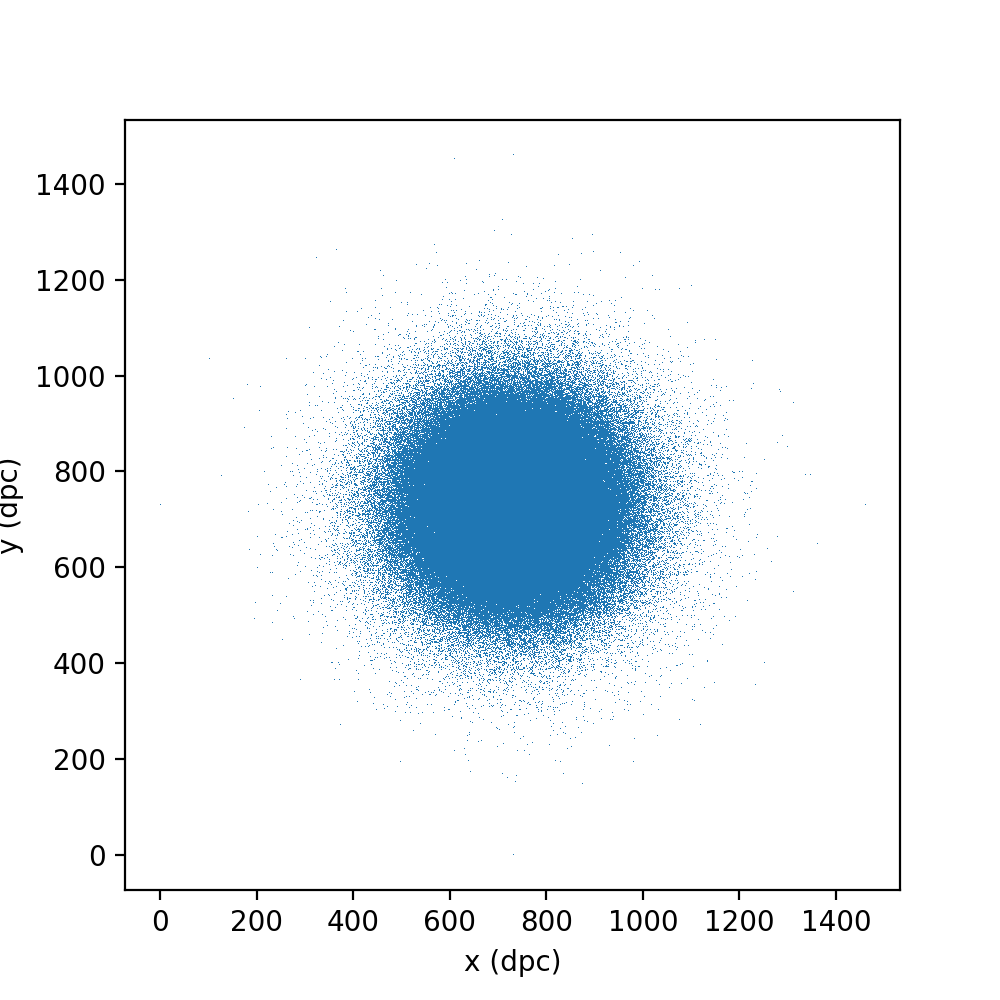

Text(0, 0.5, 'y (dpc)')

In [186]:
plt.figure(figsize=(5,5))
plt.plot(partsBH.x[:,0],partsBH.x[:,1],',')
plt.xlabel('x (dpc)')
plt.ylabel('y (dpc)')

I chose all the masses to be $1M_{\odot}$ because in $\omega\ Cen$ almost all stars are low mass stars with masses of about $0.5-1.5M_{\odot}$.

In [187]:
partsBH.m=np.ones(len(xx1))

In [188]:
partsBH.x[-1]

array([730., 730.])

Let's look the density profile.

In [189]:
partsBH.get_kernel()
partsBH.get_rho()
partsBH.get_pot()

<IPython.core.display.Javascript object>


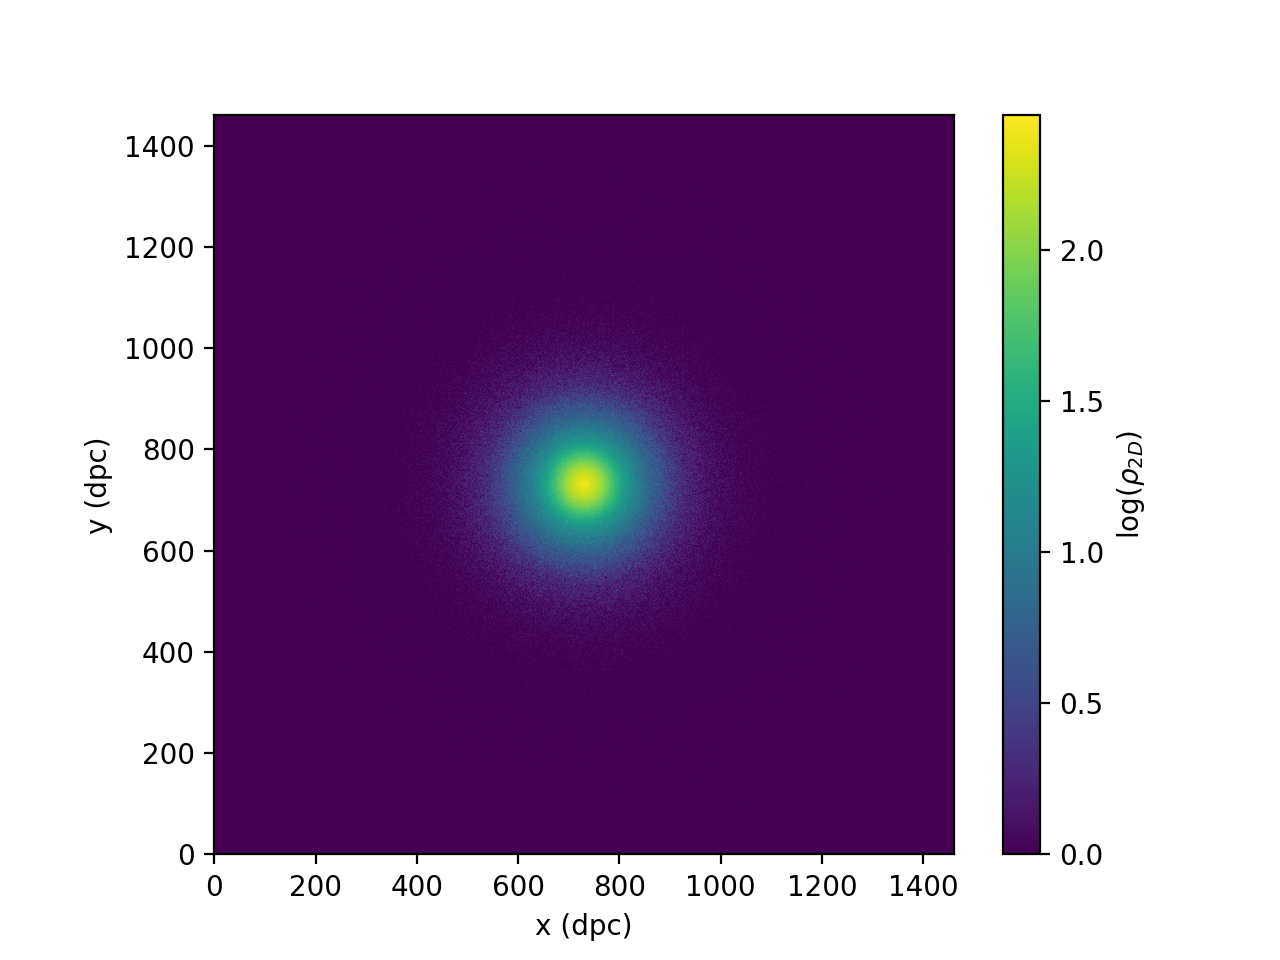

In [192]:
plt.imshow(np.log10(partsBH.rho+1))
plt.xlim(0,1460)
plt.ylim(0,1460)
plt.xlabel('x (dpc)')
plt.ylabel('y (dpc)')
plt.colorbar(label=r'$\log(\rho_{2D})$')

If we took a portion of the profile that crosses the center we can se that is very similar to what we obtained before for the theoretical $\rho(r)$.

<IPython.core.display.Javascript object>


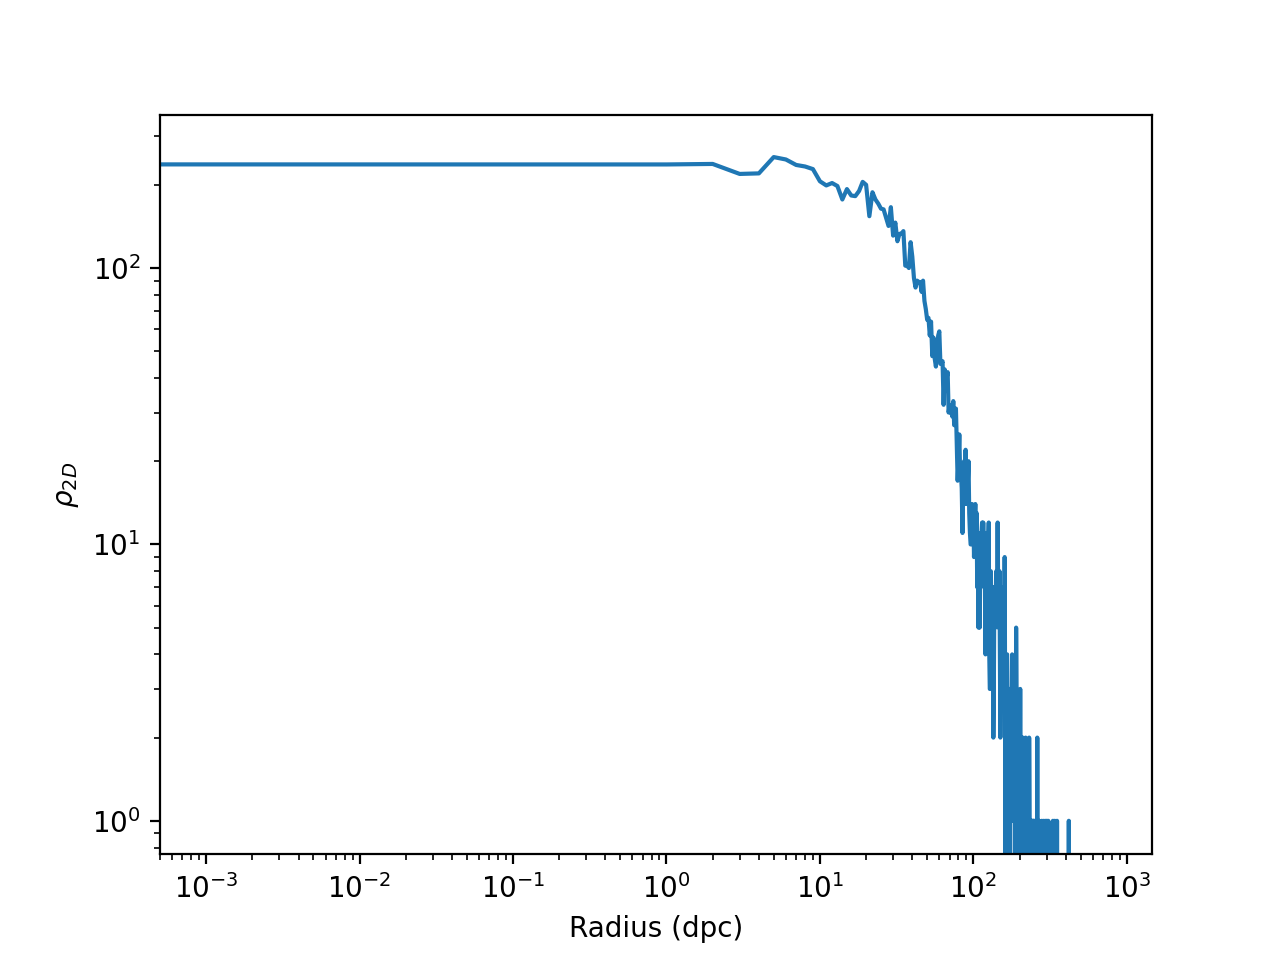

Text(0, 0.5, '$\\rho_{2D}$')

In [204]:
plt.loglog(partsBH.rho[729][729:])
plt.xlim(0.0005,1460)
plt.xlabel('Radius (dpc)')
plt.ylabel(r'$\rho_{2D}$')
#plt.colorbar()

For the velocity distribution I took the velocities from the catalogue of proper motions of $\omega\ Cen$ obtained from the Hubble Space Telescope (HST) by Bellini et al. (2014) and Watkins et al. (2015). These velocities in directions $x$ and $y$ (aligned with major and minor axis of the cluster) follow normal distributions, then we could take the mean and standard deviation to generate random velocities for our stars. Part of these data were obtained from private communication with Andrea Bellini, Laura Watkins, and Julio Chaname that are part of the projects mentioned above, then I just put the values of means and standard deviations below (in km/s).  

In [201]:
mvxW=0.07959604267438508 #km/s
mvyW=0.05769420396726823
svxW=17.14254067780904
svyW=16.43443150579307

Let's generate some velocities.

In [202]:
vxx=np.random.normal(mvxW,svxW,len(xx1))
vyy=np.random.normal(mvyW,svyW,len(xx1))

<IPython.core.display.Javascript object>


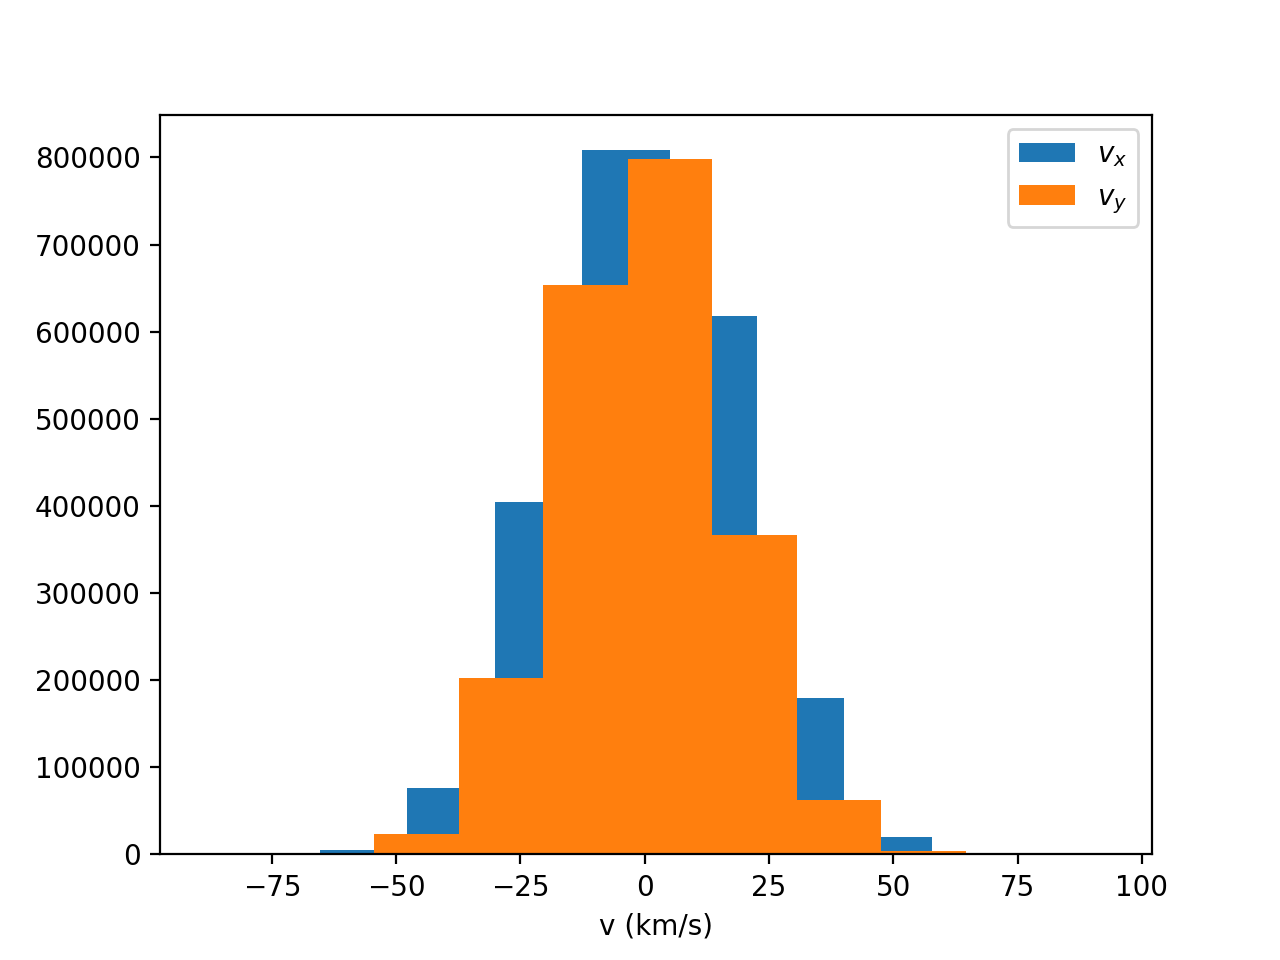

In [205]:
plt.hist(vxx,label=r'$v_{x}$')
plt.hist(vyy,label=r'$v_{y}$')
plt.xlabel('v (km/s)')
plt.legend()

Changing from km/s to $dpc/hyr$ to use our $G$.

In [206]:
vxx1=vxx*(u.km.to(u.dpc,1)/(u.s.to(u.hyr,1)))
vyy1=vyy*(u.km.to(u.dpc,1)/(u.s.to(u.hyr,1)))

<IPython.core.display.Javascript object>


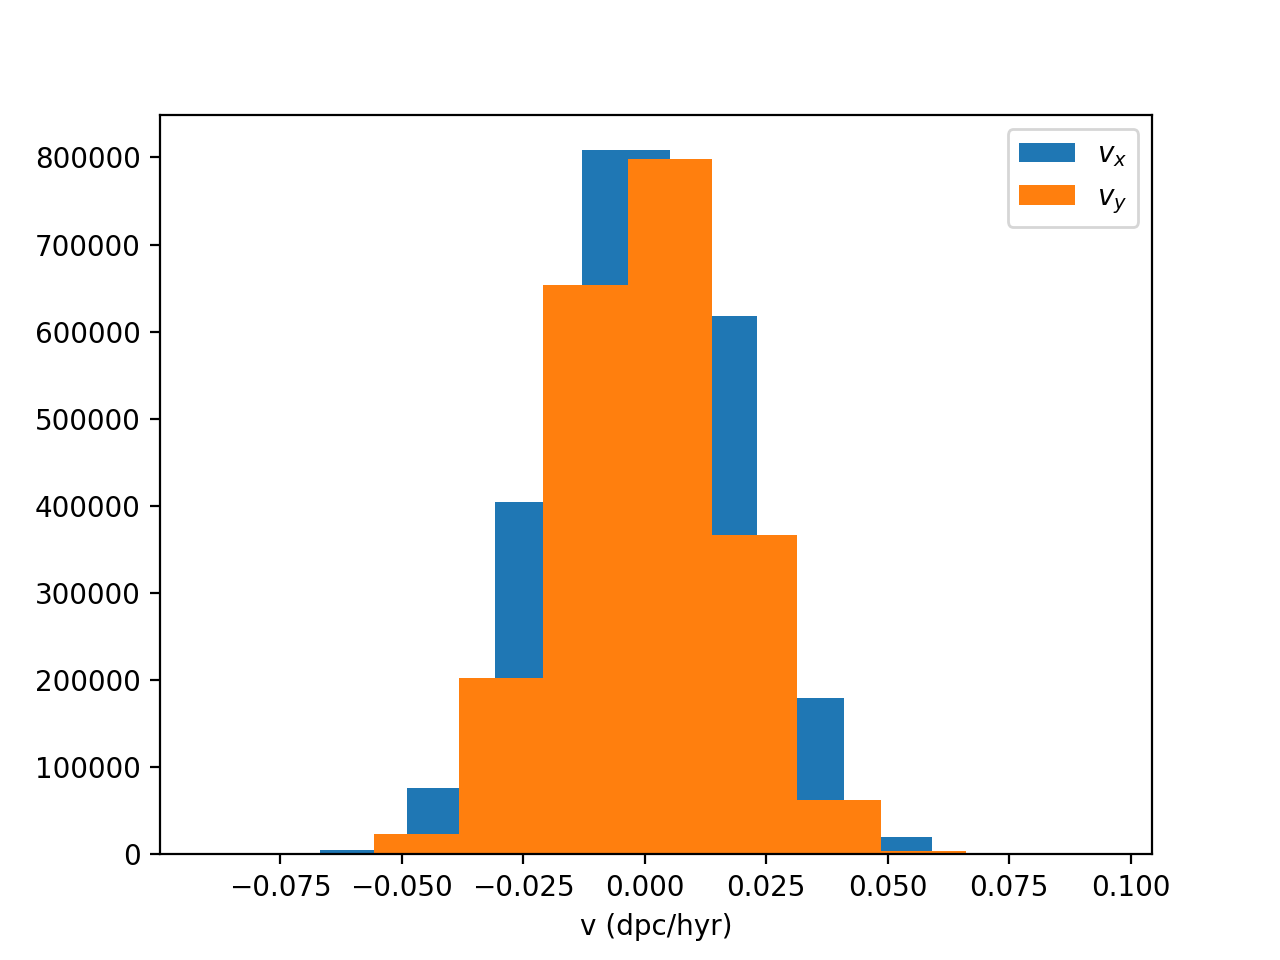

In [207]:
plt.hist(vxx1,label=r'$v_{x}$')
plt.hist(vyy1,label=r'$v_{y}$')
plt.xlabel('v (dpc/hyr)')
plt.legend()

Giving the velocities to our stars. 

In [208]:
partsBH.v=np.array([[vxx1[i],vyy1[i]] for i in range(len(xx1))])

In [209]:
partsBH.v[-1]=np.array([0,0])

In [210]:
partsBH.v[-1]

array([0., 0.])

We want to solve the system with a central IMBH, however, we need a lot of steps to see an evolution over thousand of years, and solving $>10^{6}$ stars will take a lot of computational time. Then, before adding the IMBH I'm going to save the density profile and positions for this stellar profile, and redefine the class particles and use particless_plus_rho to internally sum this stellar density profile that I saved to whatever other distribution of stars. Then, I can solve the kinematics for just a few stars but I will be able to see the effect of a stellar density profile of more than $10^{6}$ stars. Thus, last line of the method method get_rho will be self.rho=self.rho+rhost, so even if I just define just 1 star in the grid, when solving the kinematics this star will feel the effect of the potential of the stellar density profile rhost.  

On the other hand, I add the constant $G$ in the take_step solver to be consistent with the units when solving the kinematics. Then, in take_step we now have: self.v[:]=self.v[:]+G * self.f * dt.


In [217]:
rhost=partsBH.rho.copy()

In [218]:
xyBH=partsBH.x.copy()

In [74]:
#partsBH.m[-1]=4e5

In [213]:
class particles_plus_rho:
    def __init__(self,npart=10000,n=1000,soft=1,periodic=True):
        self.x=np.empty([npart,2])
        self.f=np.empty([npart,2])
        self.v=np.empty([npart,2])
        self.grad=np.empty([npart,2])
        self.m=np.empty(npart)
        self.kernel=[]
        self.kernelft=[]
        self.npart=npart
        self.ngrid=n
        if periodic:
            self.rho=np.empty([self.ngrid,self.ngrid])
            self.pot=np.empty([self.ngrid,self.ngrid])
        else:
            self.rho=np.empty([2*self.ngrid,2*self.ngrid])
            self.pot=np.empty([2*self.ngrid,2*self.ngrid])

        self.soft=soft
        self.periodic=periodic

    def get_kernel(self):
        if self.periodic:
            self.kernel=get_kernel(self.ngrid,self.soft)
            #print(self.kernel)
            #plt.imshow(np.log10(self.kernel))
            #plt.colorbar()
        else:
            self.kernel=get_kernel(2*self.ngrid,self.soft)
        self.kernelft=fft.rfft2(self.kernel)
    def get_rho(self):
        if self.periodic:
            inbound_array_np(self.x,self.ngrid)
        else:
            mask_array_np(self.x,self.m,self.ngrid)
        self.rho[:]=0
        hist2d_wmass(self.x,self.rho,self.m)
        self.rho=self.rho+rhost
        #print(hist2d_wmass(self.x,self.rho,self.m))
        #plt.imshow(hist2d_wmass(self.x,self.rho,self.m))
        #plt.colorbar()
    def get_pot(self):
        t1=time.time()
        self.get_rho()
        #print('got density: ',time.time()-t1)
        rhoft=fft.rfft2(self.rho)
        #print('got ft 1: ',time.time()-t1)
        n=self.ngrid
        if not(self.periodic):
            n=n*2
        #self.pot=fft.irfft2(rhoft*self.kernelft,[self.ngrid,self.ngrid])
        self.pot=fft.irfft2(rhoft*self.kernelft,[n,n])
        #print('got ft 2: ',time.time()-t1)
    def get_forces(self):
        get_grad(self.x,self.pot,self.grad)
        self.f[:]=self.grad
    def take_step(self,dt=1):
        self.x[:]=self.x[:]+dt*self.v
        self.get_pot()
        self.get_forces()
        self.v[:]=self.v[:]+G*self.f*dt
   
        
        
    def take_step_rk4(self,dt=1):
        #xx=np.vstack([self.x,self.v])
        v=self.v.copy()
        x=self.x.copy()
        self.get_pot()
        pot=self.pot.copy()
        grad1=np.empty([self.npart,2])
        grad2=np.empty([self.npart,2])
        grad3=np.empty([self.npart,2])
        grad4=np.empty([self.npart,2])
        
        get_grad(x,pot,grad1)
        f=grad1.copy()
        k1v=f#np.vstack([v,f])#get_derivs(xx)
        k1x=v
        
        get_grad(x+k1x*dt/2,pot,grad2)
        f2=grad2.copy()
        k2v=f2
        k2x=v+k1v*dt/2
        
        get_grad(x+k2x*dt/2,pot,grad3)
        f3=grad3.copy()
        k3v=f3
        k3x=v+k2v*dt/2
        
        get_grad(x+k3x*dt,pot,grad4)
        f4=grad4.copy()
        k4v=f4
        k4x=v+k3v*dt
        
        totx=(k1x+2*k2x+2*k3x+k4x)/6
        totv=(k1v+2*k2v+2*k3v+k4v)/6
        #nn=x.shape[0]
        self.x[:]=self.x[:]+totx*dt
        self.v[:]=self.v[:]+G*totv*dt

Finally, I'm going to solve just 25000 stars within a radius of $5\ pc=50\ dpc$. Below, I am taking some positions and velocities as before for this 25000 stars, and I am generating the object with a consistent grid.

In [214]:
partsB=particles_plus_rho(npart=25000,n=1460,soft=0.01,periodic=False)

In [215]:
partsB.m=np.ones(25000)

I defined a IMBH of $M_{BH}=2\times10^{4}M_{\odot}$ similar to what have been used before by van der Marel & Anderson (2010). The last index is the the black hole, then, the last position is at the center of the grid and the last velocity is $(0,0)$.

In [235]:
partsB.m[-1]=2e4

In [236]:
rn=np.sqrt((xyBH[:,0]-730)**2+(xyBH[:,1]-730)**2)

In [237]:
partsB.x=np.array([np.concatenate([np.random.choice(xyBH[:,0][rn<50],24995),[730.,1460.,730.,0.,730.]]),
                   np.concatenate([np.random.choice(xyBH[:,1][rn<50],24995),[1460.,730.,0.,730.,730.]])]).T

<IPython.core.display.Javascript object>


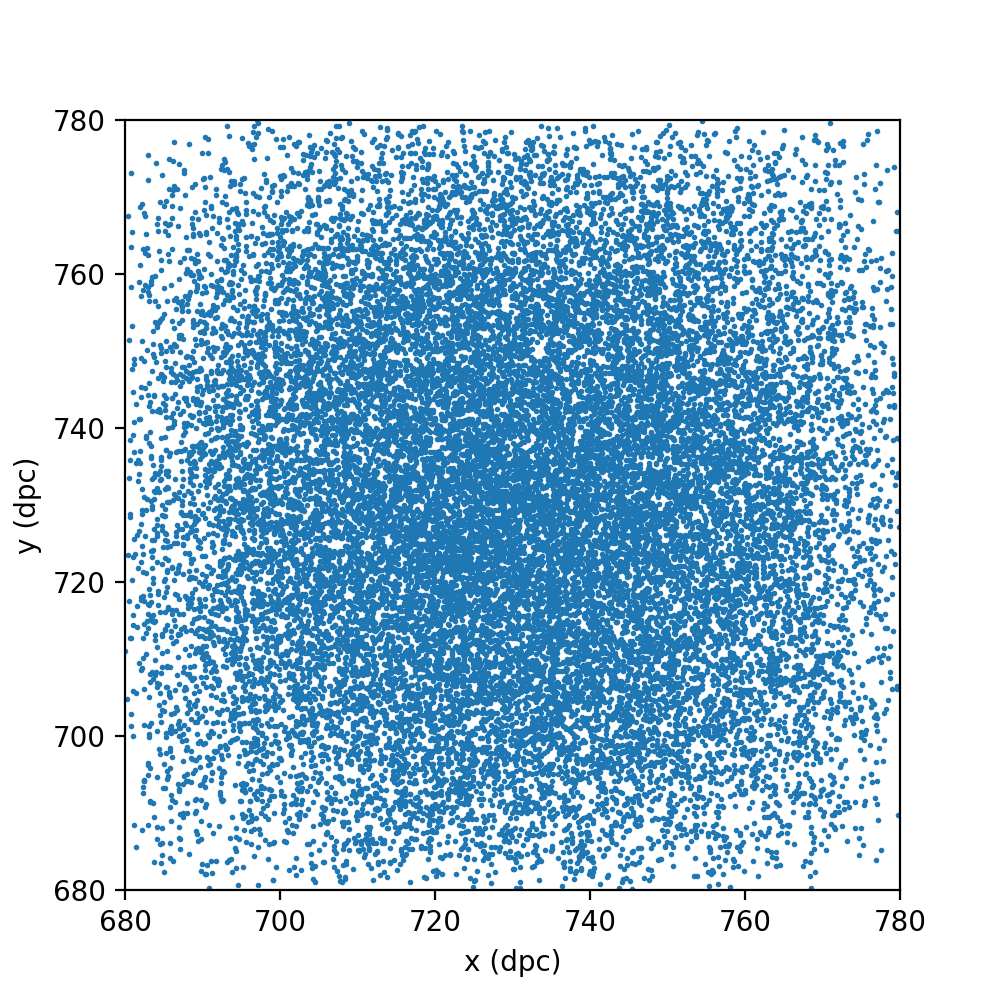

Text(0, 0.5, 'y (dpc)')

In [238]:
plt.figure(figsize=(5,5))
plt.plot(partsB.x[:,0],partsB.x[:,1],'.',markersize=2)
plt.xlim(730-50,730+50)
plt.ylim(730-50,730+50)
plt.xlabel('x (dpc)')
plt.ylabel('y (dpc)')

In [239]:
partsB.get_kernel()
partsB.get_rho()
partsB.get_pot()

We can see that the density is just amplified for a significant amount at the center.

<IPython.core.display.Javascript object>


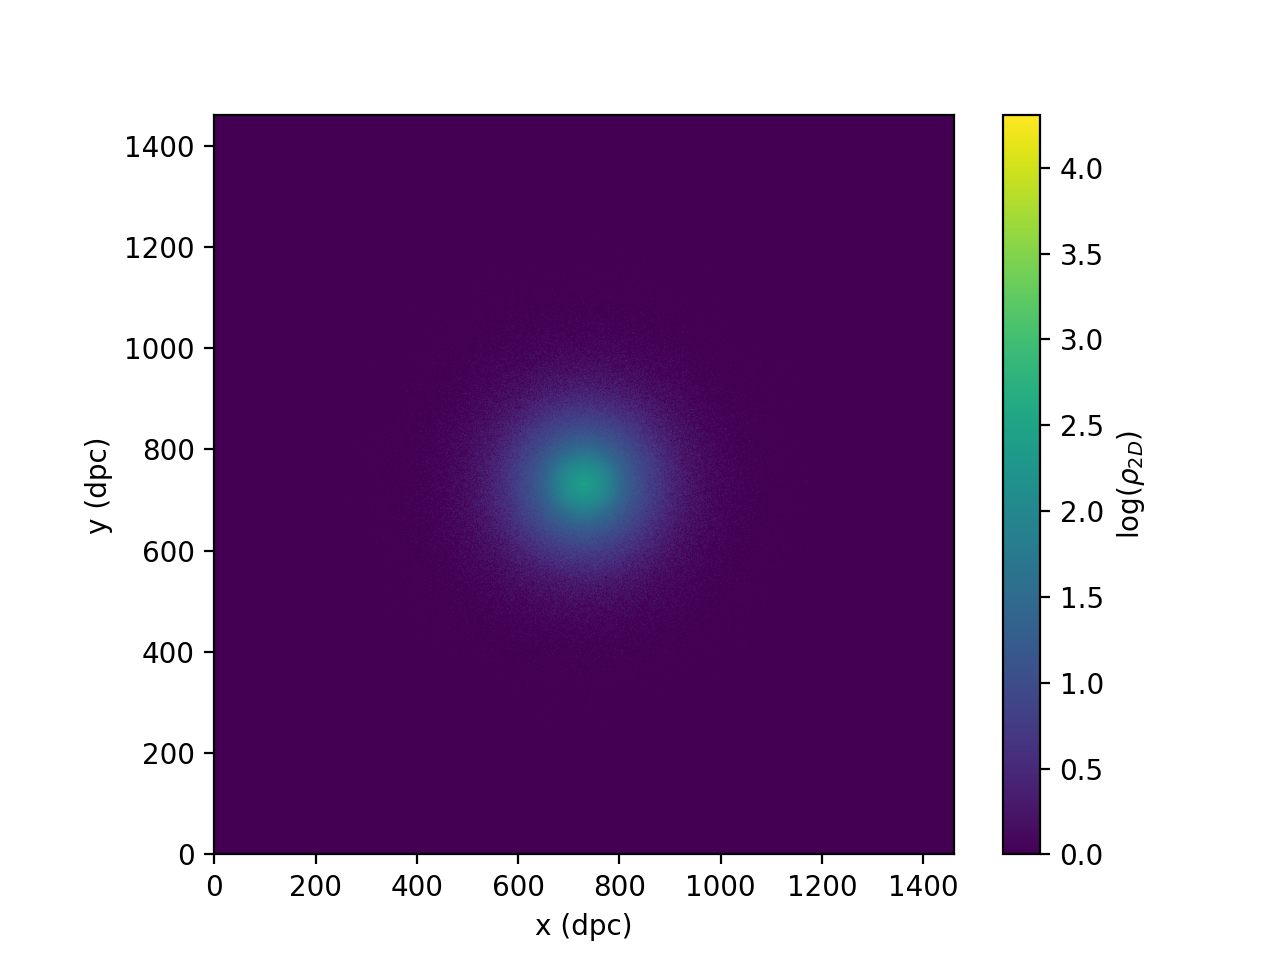

In [241]:
plt.imshow(np.log10(partsB.rho+1))
plt.xlim(0,1460)
plt.ylim(0,1460)
plt.xlabel('x (dpc)')
plt.ylabel('y (dpc)')
plt.colorbar(label=r'$\log(\rho_{2D})$')

<IPython.core.display.Javascript object>


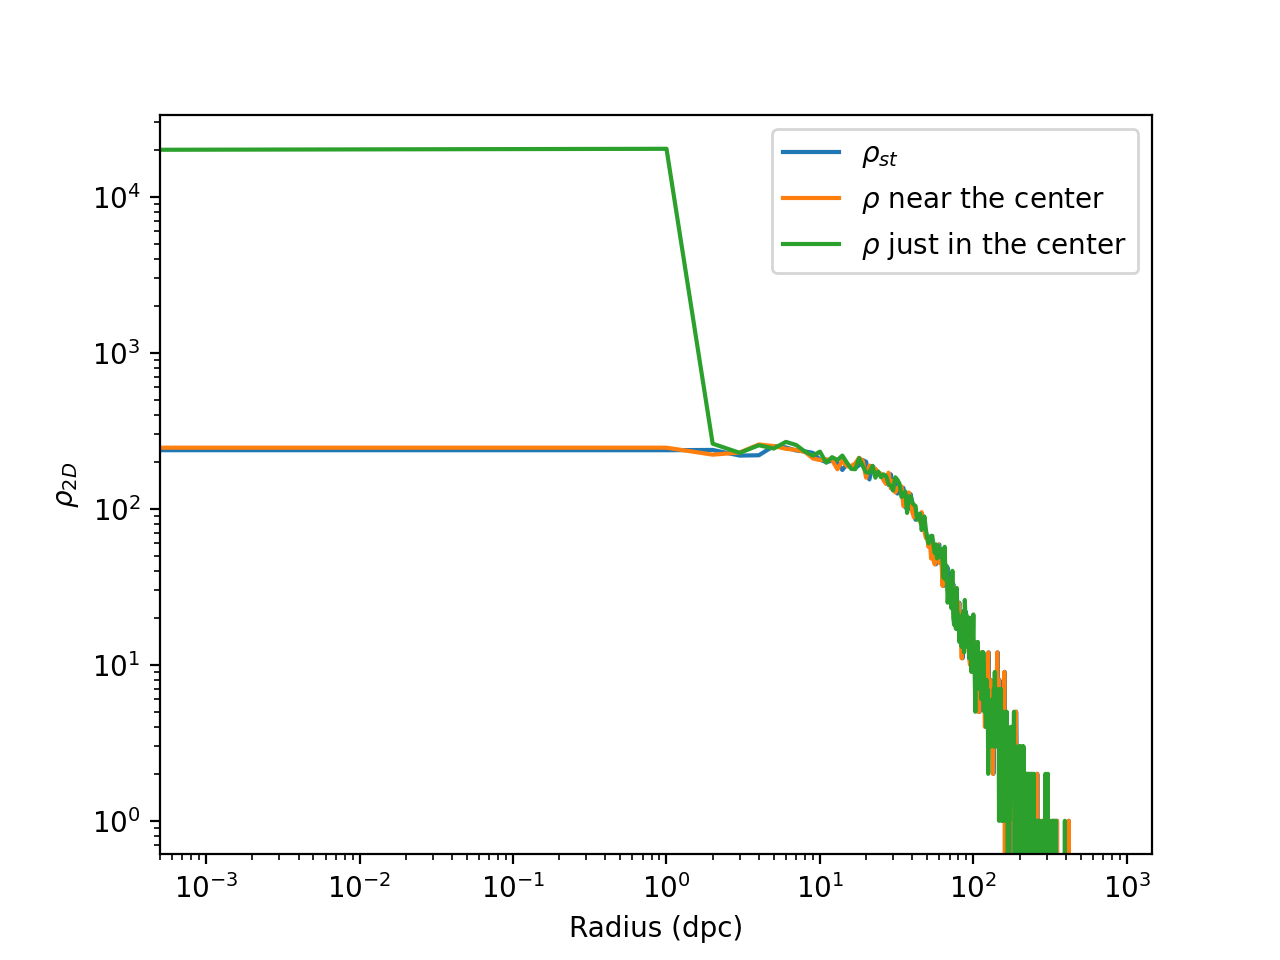

In [257]:
plt.loglog(rhost[729][729:],label=r'$\rho_{st}$')
plt.loglog(partsB.rho[729][730:],label=r'$\rho$ near the center')
plt.loglog(partsB.rho[730][729:],label=r'$\rho$ just in the center')
plt.xlim(0.0005,1460)
plt.xlabel('Radius (dpc)')
plt.ylabel(r'$\rho_{2D}$')
plt.legend()

Defining the velocities.

In [251]:
partsB.v=np.array([[vxx1[i],vyy1[i]] for i in range(len(partsB.x))])
partsB.v[-1]=np.array([0.,0.])

In [252]:
partsB.v,partsB.x,partsB.m

(array([[-0.01371408,  0.01579371],
        [-0.01507294,  0.01033179],
        [ 0.01481887,  0.00826458],
        ...,
        [-0.00410927, -0.01761935],
        [-0.01699614, -0.00499181],
        [ 0.        ,  0.        ]]),
 array([[745.62579835, 717.02472277],
        [734.98186082, 699.46078002],
        [698.903328  , 722.99148877],
        ...,
        [730.        ,   0.        ],
        [  0.        , 730.        ],
        [730.        , 730.        ]]),
 array([1.e+00, 1.e+00, 1.e+00, ..., 1.e+00, 1.e+00, 2.e+04]))

Finally, I took 400 steps that I effectively saved in a file called pos1.txt with intermediate 100 steps of $dt=0.01\ hyr$. Then, I saved the positions and velocities every $1\ hyr$. I ran this multiple times and took a lot of time, so I didn't rerun it again last time and just read the file. To avoid some numerical errors I update the positions and velocities of the black hole with every step to be at rest at the center of the grid.

In [253]:
osamp=100

In [ ]:
poss=open('pos1.txt','w')
nstep=400
xnb=np.zeros((nstep,partsB.npart,2))
vnb=np.zeros((nstep,partsB.npart,2))
ttb=[]
tt=0
for i in range(0,nstep):
    for j in range(osamp):
        partsB.take_step(dt=0.01)
        partsB.x[-1]=np.array([730.,730.])
        partsB.v[-1]=np.array([0.,0.])
        tt+=0.01
        #print(tt)
    xnb[i]=partsB.x
    vnb[i]=partsB.v
    ttb.append(tt)
    #for k in range(len(xnb)):
    poss.write(str(ttb[i])+'\n')
    for l in range(len(xnb[i])):
        poss.write(str(xnb[i][l][0])+','+str(xnb[i][l][1])+','+str(vnb[i][l][0])+','+str(vnb[i][l][1])+'\n')
    #partsn.get_kernel()
    #partsn.get_rho()
    #partsn.get_pot()
    #rhon[i]=partsn.rho
    #print(tt,np.min(xnb[i]),np.max(xnb[i]),np.min(vnb[i]),np.max(vnb[i]))
poss.close()

In [258]:
pos1=open('pos1.txt')
lp=[(d.strip()).split(',') for d in pos1.readlines()]
pos1.close()

In [314]:
ttb=np.array([round(float(i[0]),3) for i in lp[0:-1:25001]])
xnb=[]
vnb=[]
for i in range(400):
    ux=np.array([np.array(lp[1+i*25001:25001*(i+1)])[:,0],np.array(lp[1+i*25001:25001*(i+1)])[:,1]],dtype='float64').T
    xnb.append(ux)
    uv=np.array([np.array(lp[1+i*25001:25001*(i+1)])[:,2],np.array(lp[1+i*25001:25001*(i+1)])[:,3]],dtype='float64').T
    vnb.append(uv)

In [316]:
xnb=np.array(xnb)
vnb=np.array(vnb)

Some animation of the change in the positions omcen1.gif, omcen2.gif, and omcen3.gif:

<IPython.core.display.Javascript object>


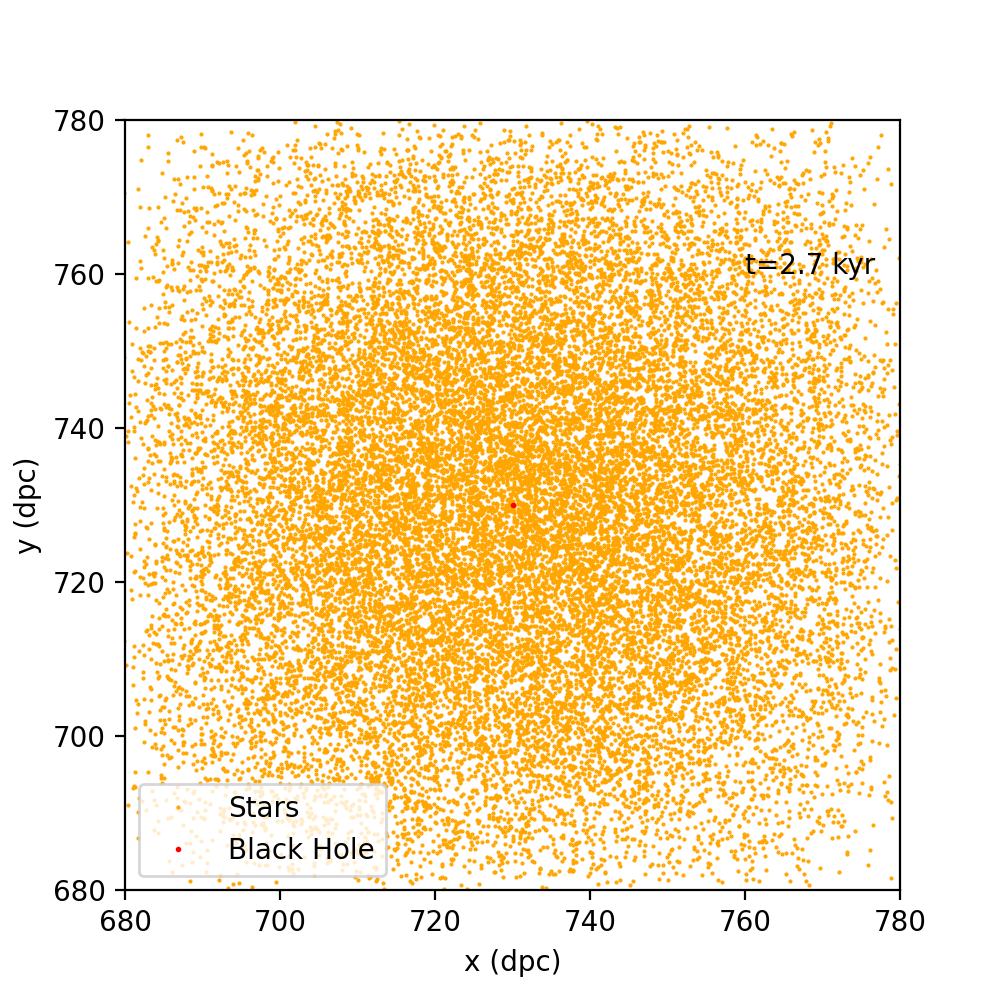

In [334]:
fig,ax = plt.subplots(figsize=(5,5))
nm=50
def animate(i):
    ax.clear()
    ax.set_xlim(730-nm,730+nm)
    ax.set_ylim(730-nm,730+nm)
    #ax.set_xlim(730-50,730+50)
    #ax.set_ylim(730-50,730+50)
    #ax.set_xlim(-0.1,0.1)
    #ax.set_ylim(-0.1,0.1)
    #line, = ax.plot(x1[0:i], y1[0:i], color = 'blue', lw=1)
    #line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
    #line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
    point1, = ax.plot(xnb[i][:,0],xnb[i][:,1],'o',label='Stars',markersize=0.5,color='orange')
    point2, = ax.plot(xnb[i][:,0][-1],xnb[i][:,1][-1],'o',label='Black Hole',markersize=1,color='red')
    ax.text(710+nm,710+nm,'t='+str(round(ttb[i],3)/10)+' kyr')
    ax.legend()
    ax.set_xlabel('x (dpc)')
    ax.set_ylabel('y (dpc)')
    #print(i)
    #point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
    return point1, point2,# point3,
        
ani = FuncAnimation(fig, animate, frames=400, blit=True, repeat=True, interval=100)    
ani.save("omcen1.gif", dpi=300, writer=PillowWriter(fps=25))
plt.show()

<IPython.core.display.Javascript object>


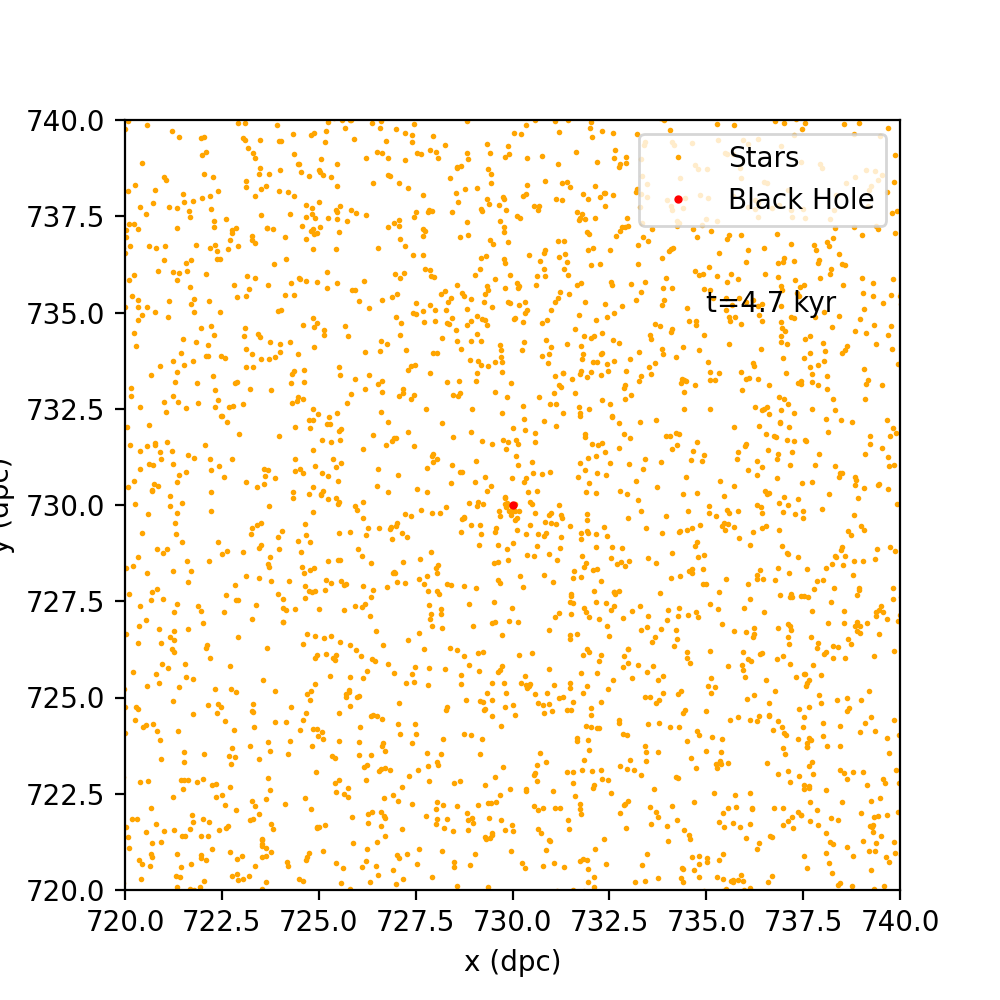

In [335]:
fig,ax = plt.subplots(figsize=(5,5))
nm=10
def animate(i):
    ax.clear()
    ax.set_xlim(730-nm,730+nm)
    ax.set_ylim(730-nm,730+nm)
    #ax.set_xlim(730-50,730+50)
    #ax.set_ylim(730-50,730+50)
    #ax.set_xlim(-0.1,0.1)
    #ax.set_ylim(-0.1,0.1)
    #line, = ax.plot(x1[0:i], y1[0:i], color = 'blue', lw=1)
    #line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
    #line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
    point1, = ax.plot(xnb[i][:,0],xnb[i][:,1],'o',label='Stars',markersize=1,color='orange')
    point2, = ax.plot(xnb[i][:,0][-1],xnb[i][:,1][-1],'o',label='Black Hole',markersize=2,color='red')
    ax.text(725+nm,725+nm,'t='+str(round(ttb[i],3)/10)+' kyr')
    ax.legend()
    ax.set_xlabel('x (dpc)')
    ax.set_ylabel('y (dpc)')
    ax.legend(loc=1)
    #print(i)
    #point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
    return point1, point2,# point3,
        
ani = FuncAnimation(fig, animate, frames=400, blit=True, repeat=True, interval=100)    
ani.save("omcen2.gif", dpi=300, writer=PillowWriter(fps=25))
plt.show()

<IPython.core.display.Javascript object>


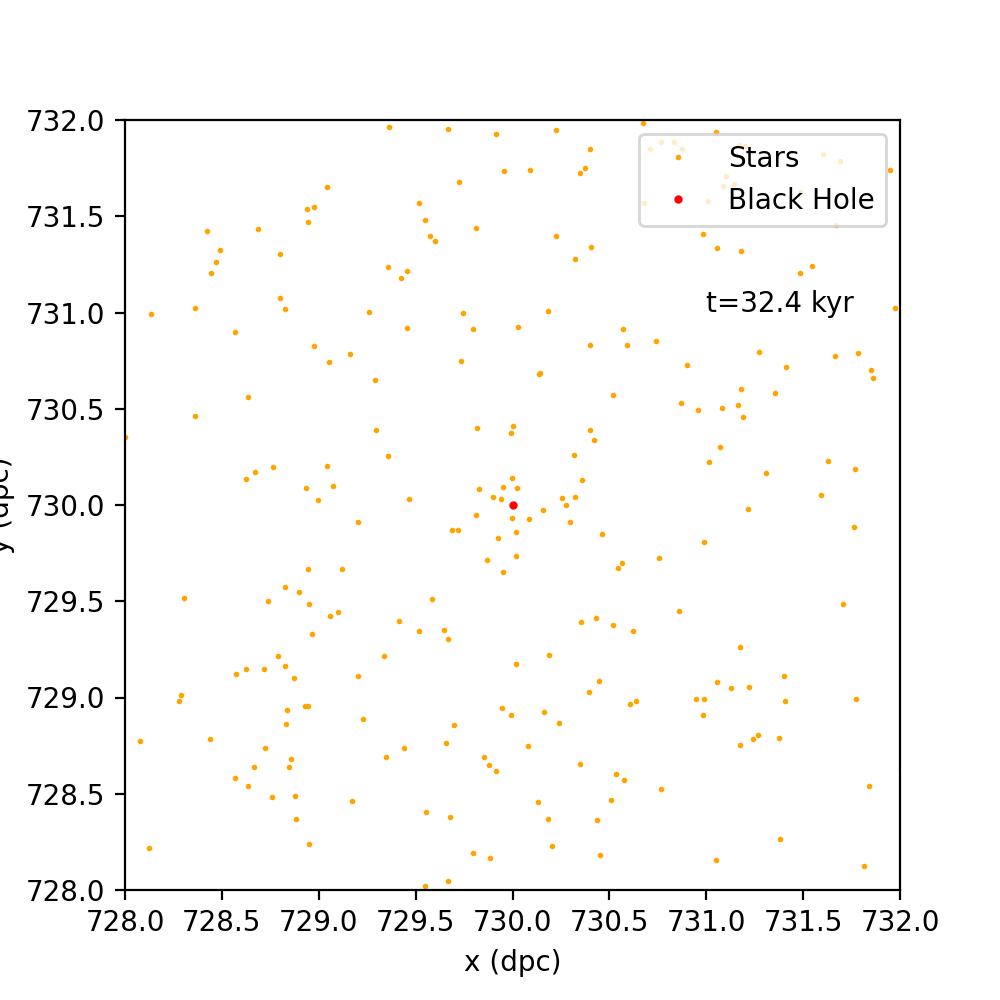

In [338]:
fig,ax = plt.subplots(figsize=(5,5))
nm=2
def animate(i):
    ax.clear()
    ax.set_xlim(730-nm,730+nm)
    ax.set_ylim(730-nm,730+nm)
    #ax.set_xlim(730-50,730+50)
    #ax.set_ylim(730-50,730+50)
    #ax.set_xlim(-0.1,0.1)
    #ax.set_ylim(-0.1,0.1)
    #line, = ax.plot(x1[0:i], y1[0:i], color = 'blue', lw=1)
    #line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
    #line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
    point1, = ax.plot(xnb[i][:,0],xnb[i][:,1],'o',label='Stars',markersize=1,color='orange')
    point2, = ax.plot(xnb[i][:,0][-1],xnb[i][:,1][-1],'o',label='Black Hole',markersize=2,color='red')
    ax.text(729+nm,729+nm,'t='+str(round(ttb[i],3)/10)+' kyr')
    ax.legend()
    ax.set_xlabel('x (dpc)')
    ax.set_ylabel('y (dpc)')
    ax.legend(loc=1)
    #print(i)
    #point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
    return point1, point2,# point3,
        
ani = FuncAnimation(fig, animate, frames=400, blit=True, repeat=True, interval=100)    
ani.save("omcen3.gif", dpi=300, writer=PillowWriter(fps=10))
plt.show()

Now we should compute some velocity dispersions per radial bin, i.e., we take some ring which is between two radius and we obtain the dispersion of the velocities there. The total dispersion that we will use will be (e.g., Evans et al. 2021):
$$\sigma(r)=\sqrt{(\sigma_{x}^{2}+\sigma_{y}^{2})/2}$$
where every $\sigma_{i}^{2}=\bar{v_{i}^{2}}-\bar{v_{i}}^{2}$. Let's take the radius in arcsec and the velocities in km/s, which is typically used for the radial binning.

In [339]:
xab=(u.dpc.to(u.pc,1)*(xnb-730)*(648)/(np.pi*D))
vab=(u.dpc.to(u.km,1)/u.hyr.to(u.s,1))*vnb

In [340]:
rab=[]
for i in range(400):
    rab.append(np.sqrt((xab[i][:,0])**2+(xab[i][:,1])**2)[0:-1])

Routine for binning taking the first bin to be between 0 to 4 arcsec and the following separated by 2 arcsec. We will ignore the velocities with absolute value >75 km/s which is a rough estimation for the escape velocity $v_{esc}=\sqrt{2GM_{t}/R}$ taking a $R=5\ pc$.

In [341]:
np.sqrt(u.Msun.to(u.kg,Mt)*2*6.67e-11/u.pc.to(u.m,5))/1000

74.98456367341366

In [345]:
def binn(r,v):
    vradx=[]
    vrady=[]
    vvradx1=[]
    vvrady1=[]
    for j in range(0,len(v)):
        if 0<=r[j]<4.:
            if -75<v[:,0][j]<75 and -75<v[:,1][j]<75:
                vvradx1.append(v[:,0][j])
                vvrady1.append(v[:,1][j])
    #print(vvradx1)
    vradx.append(np.array(vvradx1))
    vrady.append(np.array(vvrady1))
    
    for i in range(4,200):
        vvx=[]
        vvy=[]
        for j in range(0,len(v)):
            #if (i+0.55)<=r[j]<(i+2.55):
            if (i+0.)<=r[j]<(i+2.):
                #if -160<v[:,0][j]<160 and -160<v[:,1][j]<160:
                if -75<v[:,0][j]<75 and -75<v[:,1][j]<75:
                    vvx.append(v[:,0][j])
                    vvy.append(v[:,1][j])
        vradx.append(np.array(vvx))
        vrady.append(np.array(vvy))
        
   # vvradx1=[]
   # vvrady1=[]
    #rad1=[]
    
#rad1.append(1.55)

    #vvradxl=[]
    #vvradyl=[]
    #for j in range(0,len(vxp4)):
      #  if 70.55<=r4[j]:
       #     vvradxl.append(v[:,0][j])
        #    vvradyl.append(v[:,0][j])
#radl.append(71.7)

    vvvx=np.array(vradx)#+[vvradxl])
    vvvy=np.array(vrady)#+[vvradyl])
    
    vmx2=[]
    vsqx=[]
    vmy2=[]
    vsqy=[]
    for i in range(len(vvvx)):
        vmx2.append(np.mean(vvvx[i])**2)
        vsqx.append(np.mean(vvvx[i]**2))
        vmy2.append(np.mean(vvvy[i])**2)
        vsqy.append(np.mean(vvvy[i]**2))
    #print(vsqx)
    dispx=np.sqrt(np.array(vsqx)-np.array(vmx2))
    dispy=np.sqrt(np.array(vsqy)-np.array(vmy2))
    dispt=np.sqrt((dispx**2+dispy**2)/2)
    #print(dispt)
    return dispt

In [ ]:
disps=[]
for i in range(400): #dispersions for each time
    disps.append(binn(rab[i],vab[i][0:-1]))
    #print(i)

Radial distance bins defined for every ring as $(R_{out}+R_{in})/2$.

In [347]:
raddd=np.array([2]+[((i+0.)+(i+2.))/2 for i in range(4,200)])

Below, I copied some radial bins and velocity dispersions obtained for $\omega\ Cen$ by van der Marel & Anderson (2010), and Watkins et al. (2015) to compare with our modeled dispersions.

In [348]:
radwat=np.array([  2.283,   4.326,   6.015,   7.867,   9.468,  12.396,  16.134,
        18.778,  29.914,  43.938,  54.507,  63.378,  71.502,  78.799,
        85.65 ,  92.193,  98.406, 104.181, 109.723, 115.151, 120.666,
       125.902, 131.322, 136.877, 142.98 , 150.199, 162.184, 236.835])
sgwat=np.array([17.77058266, 20.06580469, 22.84540799, 20.35394945, 20.182553  ,
       19.7279798 , 20.06332069, 18.99768189, 18.5853368 , 18.32203211,
       17.99414325, 17.65383436, 17.86745892, 17.56689413, 17.26881335,
       16.9458925 , 17.09244888, 16.8713723 , 16.12865435, 16.71984791,
       16.49380331, 16.36960299, 16.23298263, 15.98706598, 15.81566953,
       15.55484885, 15.52752477, 15.08288761])
esgwat=np.array([1.92262105, 2.01204528, 1.48295189, 1.2196472 , 1.18735512,
       0.6483257 , 0.71539388, 0.75016997, 0.19375251, 0.20368853,
       0.20617254, 0.18381648, 0.1912685 , 0.1912685 , 0.1887845 ,
       0.17636446, 0.18133248, 0.1887845 , 0.17884847, 0.17636446,
       0.1887845 , 0.17636446, 0.16394443, 0.17388046, 0.16394443,
       0.16146042, 0.14655638, 0.16146042])
radavm=np.array([ 0.775,  2.05 ,  3.05 ,  4.05 ,  5.05 ,  6.05 ,  7.05 ,  8.05 ,
        9.05 , 10.05 , 11.05 , 12.05 , 13.05 , 14.05 , 15.05 , 16.05 ,
       17.05 , 18.05 , 19.05 , 20.05 , 21.05 , 22.05 , 23.05 , 24.05 ,
       25.05 , 26.05 , 27.05 , 28.05 , 29.05 , 30.05 , 31.05 , 32.05 ,
       33.05 , 34.05 , 35.05 , 36.05 , 37.05 , 38.05 , 39.05 , 40.05 ,
       41.05 , 42.05 , 43.05 , 44.05 , 45.05 , 46.05 , 47.05 , 48.05 ,
       49.05 , 50.05 , 51.05 , 52.05 , 53.05 , 54.05 , 55.05 , 56.05 ,
       57.05 , 58.05 , 59.05 , 60.05 , 61.05 , 62.05 , 63.05 , 64.05 ,
       65.05 , 66.05 , 67.05 , 68.05 , 69.05 , 70.05 , 71.125])
sgavm=np.array([19.26855943, 18.48150657, 20.32839971, 17.63526329, 21.9659588 ,
        20.98287243, 20.14524408, 17.27829317, 17.72815246, 19.02314643,
        19.66921086, 20.71094279, 18.73209224, 19.0275749 , 18.82618032,
        19.42698782, 19.05200932, 19.5063975 , 19.67465429, 19.62107186,
        18.57944895, 18.62038688, 18.31418841, 19.23725399, 18.51679636,
        18.71518108, 18.74863413, 17.99894232, 18.63189111, 19.69950217,
        18.87819729, 18.48861101, 19.50873378, 18.42642107, 18.29129886,
        18.91724591, 18.61546055, 17.93251394, 18.59715054, 17.62513389,
        18.7171776 , 18.42860869, 18.88020354, 18.56002691, 17.53206973,
        17.94800282, 17.65485665, 18.95451394, 18.77306235, 18.52920919,
        18.09519539, 17.83421968, 18.12255659, 17.96888686, 18.04204435,
        18.2014929 , 18.3593091 , 17.33863892, 18.09765086, 18.04769728,
        17.73428492, 17.99668443, 17.96982376, 18.09557676, 17.78018782,
        18.08253284, 17.44344465, 17.69241007, 17.93863495, 17.65309535,
        17.91631263])
esgavm=np.array([2.5232533 , 2.28999391, 2.16918036, 1.80922036, 1.87359875,
        1.64482007, 1.64260924, 1.30180287, 1.24037939, 1.34944195,
        1.3748564 , 1.3965276 , 1.24576808, 1.18621463, 1.15924147,
        1.09333622, 1.05165167, 1.07322385, 1.0204149 , 0.99477341,
        0.93569251, 0.87662877, 0.83346972, 0.87548347, 0.83611846,
        0.80561123, 0.73309676, 0.75307876, 0.80926497, 0.84985009,
        0.78727449, 0.73555589, 0.78420093, 0.72843206, 0.67527283,
        0.72973877, 0.692074  , 0.67414123, 0.6478263 , 0.62904454,
        0.6374334 , 0.64072226, 0.66472139, 0.614906  , 0.60901168,
        0.59548458, 0.57208203, 0.62620436, 0.60341463, 0.6130686 ,
        0.58068709, 0.57403957, 0.57133703, 0.57477904, 0.55444617,
        0.5530109 , 0.53929441, 0.51904284, 0.54684671, 0.55402294,
        0.5218019 , 0.54352371, 0.51144631, 0.53092851, 0.53082408,
        0.52959809, 0.51320228, 0.52220168, 0.50734891, 0.50025178,
        0.46318076])

Finally, I look at the dispersion of the N-body simulation at some times to compare with the data.

In [349]:
aa=[74,109,140,216,222,229,231,242,275,297,320,341,381]

<IPython.core.display.Javascript object>


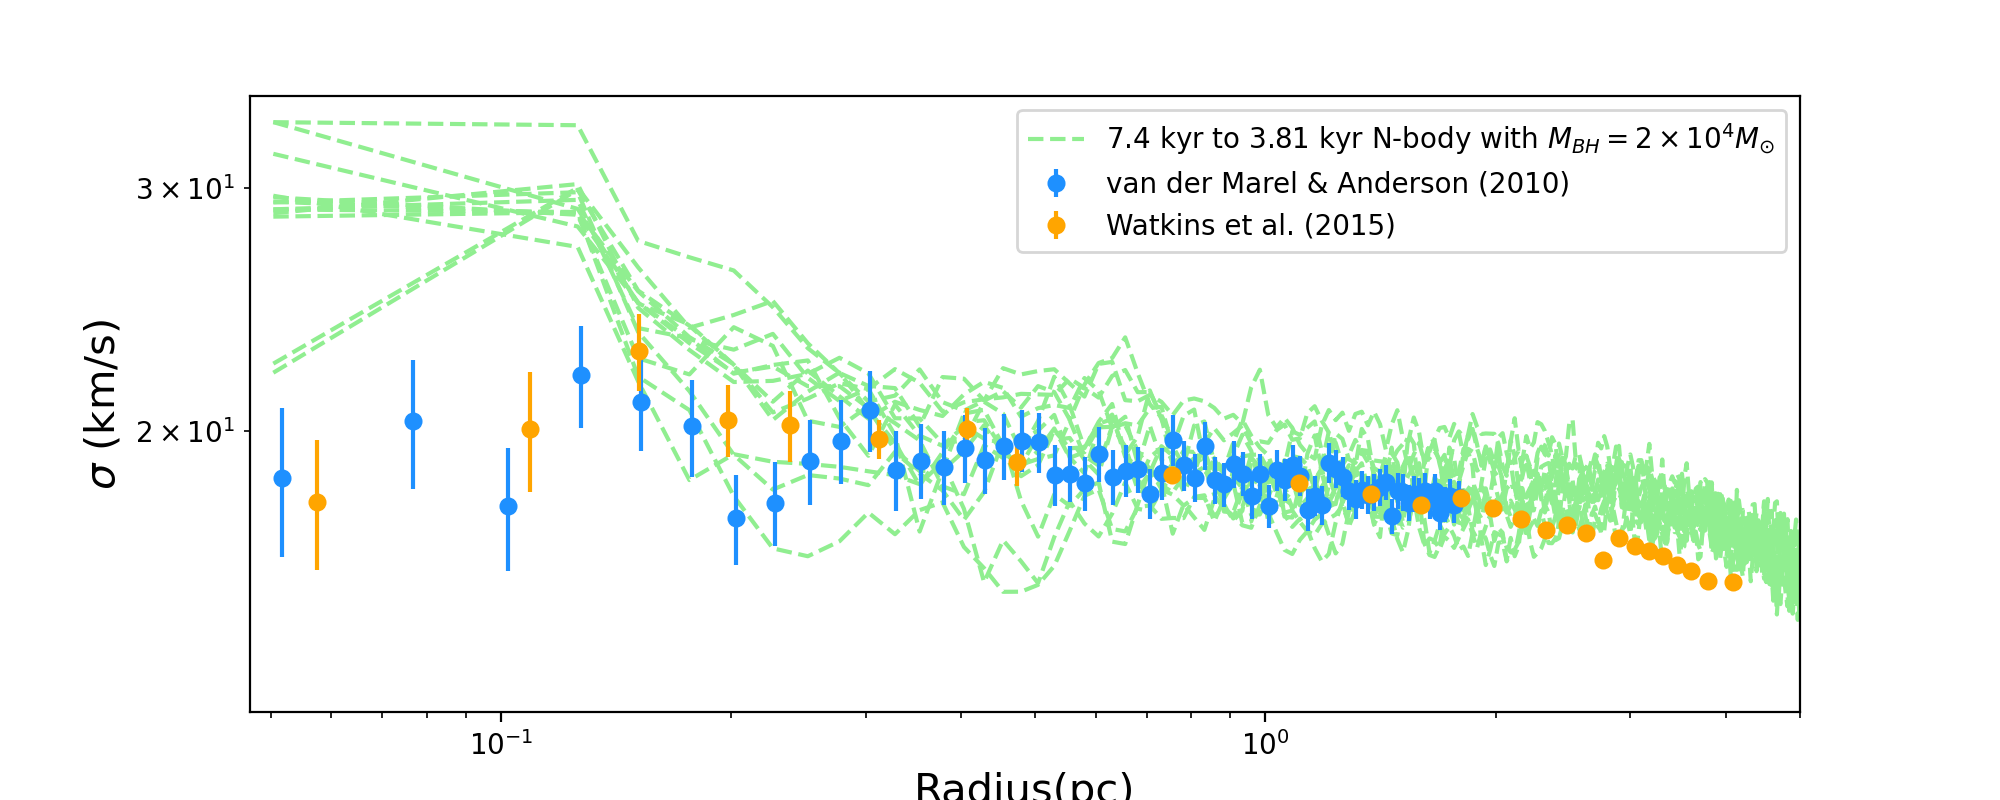

In [358]:
plt.figure(figsize=(10,4))
for i in aa:
    plt.semilogx(raddd*D*np.pi/648,disps[i],'--',color='lightgreen')#,label='7.4 kyr to 3.81 kyr')
plt.semilogx([],[],'--',color='lightgreen',
             label='7.4 kyr to 3.81 kyr N-body with $M_{BH}=2\\times 10^{4}M_{\odot}$')#'mediumspringgreen')
#plt.semilogx(raddd*D*np.pi/648,disps[99],'--',color='yellowgreen')
#plt.semilogx(raddd*D*np.pi/648,disps[186],'--',color='green')
#plt.semilogx(raddd*D*np.pi/648,disps[159],'--',color='yellowgreen')
#plt.semilogx(raddd*D*np.pi/648,disps[199],'--',color='yellowgreen')
#plt.semilogx(raddd*D*np.pi/648,disps[299],'--',color='yellowgreen')
#plt.semilogx(raddd*D*np.pi/648,disps[259],'--',color='yellowgreen')
plt.errorbar(radavm*D*np.pi/648, sgavm, yerr=esgavm,fmt='o',markersize=5.5,color='dodgerblue',
             label='van der Marel & Anderson (2010)')
plt.errorbar(radwat*D*np.pi/648, sgwat, yerr=esgwat,fmt='o',markersize=5.5,color='orange',
             label='Watkins et al. (2015)')
plt.ylim(12.5,35)
plt.xlim(0.047,5)
plt.xlabel('Radius(pc)',fontsize=15)
plt.ylabel(r'$\sigma$ (km/s)',fontsize=15)
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend()
#plt.legend(loc=0)

I put again the distances in $pc$. We can see that some dispersions could be explained with our model, however, as we go closer to the center of the cluster the black hole is scattering the velocities to larger values. To see if the IMBH model could work better we could take more timesteps or different values for the mass of the IMBH. Moreover, we could try a 3D computation or a grid for the simulation defined with more resolution for the density. On the other hand, some studies have proposed that some profile of dark matter could work to make a better fit for this data (e.g., Evans et al. 2021). Although this model is far for being complete we were able to explain some of the data, I haven't had enough time to explore more possibilities, but at least I made the previous plot. 

# References

Evans, A. J., Strigari, L. E., and Zivick, P., “Dark and luminous mass components of Omega Centauri from stellar kinematics”, Monthly Notices of the Royal Astronomical Society, vol. 511, no. 3, pp. 4251–4264, 2022. doi:10.1093/mnras/stac261.

Baumgardt, H. and Hilker, M., “A catalogue of masses, structural parameters, and velocity dispersion profiles of 112 Milky Way globular clusters”, Monthly Notices of the Royal Astronomical Society, vol. 478, no. 2, pp. 1520–1557, 2018. doi:10.1093/mnras/sty1057.

Watkins, L. L., van der Marel, R. P., Bellini, A., and Anderson, J., “Hubble Space Telescope Proper Motion (HSTPROMO) Catalogs of Galactic Globular Cluster. II. Kinematic Profiles and Maps”, The Astrophysical Journal, vol. 803, no. 1, 2015. doi:10.1088/0004-637X/803/1/29.

Bellini, A., “Hubble Space Telescope Proper Motion (HSTPROMO) Catalogs of Galactic Globular Clusters. I. Sample Selection, Data Reduction, and NGC 7078 Results”, The Astrophysical Journal, vol. 797, no. 2, 2014. doi:10.1088/0004-637X/797/2/115.

Watkins, L. L., van de Ven, G., den Brok, M., and van den Bosch, R. C. E., “Discrete dynamical models of ω Centauri”, Monthly Notices of the Royal Astronomical Society, vol. 436, no. 3, pp. 2598–2615, 2013. doi:10.1093/mnras/stt1756.

Anderson, J. and van der Marel, R. P., “New Limits on an Intermediate-Mass Black Hole in Omega Centauri. I. Hubble Space Telescope Photometry and Proper Motions”, The Astrophysical Journal, vol. 710, no. 2, pp. 1032–1062, 2010. doi:10.1088/0004-637X/710/2/1032.

van der Marel, R. P. and Anderson, J., “New Limits on an Intermediate-Mass Black Hole in Omega Centauri. II. Dynamical Models”, The Astrophysical Journal, vol. 710, no. 2, pp. 1063–1088, 2010. doi:10.1088/0004-637X/710/2/1063.